In [6]:
# Analysis libraries
import numpy as np
import pandas as pd
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
from scipy.special import gamma, hyp2f1
from scipy.stats import ks_2samp, kstest

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.ticker as tck
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import shapely 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm, SymLogNorm

# Other libraries
import os
import sys
import re
import itertools
from tqdm import tqdm
import pickle


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
sys.path.append('../scripts')
from utils import *
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_SAD(data, nbins):
    if len(data) < nbins:
        return None
    else:
        bins = np.logspace(np.log10(min(data)), np.log10(max(data)), nbins)
        counts, _ = np.histogram(data, bins=bins)
        prob = counts / counts.sum()
        pdf = prob / np.diff(bins)
        x = np.sqrt(bins[1:] * bins[:-1])
        y = pdf
        x = x[y > 0]
        y = y[y > 0]
        return x, y

In [8]:
sns.set(font='Avenir', font_scale=1., style='ticks')
figsize_geo = (10,7.5)

colorSRF = '#7BC8F6'
colorDCM = '#000033'

palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)

golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)

sns.set(rc={'figure.figsize':(3.5,3.5), 'figure.dpi':200, 'savefig.dpi':400})
sns.set_theme(font="Avenir", font_scale=1., style="ticks")

In [9]:
data_dir = '../../data/processed/'
fig_dir = '../../fig/'
os.makedirs(fig_dir, exist_ok=True)

## Metadata

In [10]:
# topID metaB key
filename = os.path.join(data_dir, 'Tara/topID_metaB_key.csv')
topID_metaB_key = pd.read_csv(filename, index_col=0)
topID_metaB_key.head()

taxon    level
md5sum                                                       
00b5bb3b1cae64e4d2761e16fc91b2cb           Proboscia    genus
039a44f7c456a8d518a656d4bddb3594  Odontella sinensis  species
044e857fc8eb5fd22318010046f420af         Chaetoceros    genus
0dee4375a6cbe9d2a091e451b1a96370  Guinardia flaccida  species
14b113961e0805fb5e1bb3b40d828f52    Corethron inerme  species

In [11]:
# import metadata

filename_meta = os.path.join(data_dir, 'Tara/woa_pisces_tarassd.tsv')
df = pd.read_csv(filename_meta, sep ='\t')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="ESRI:54030")
# rename SUR to SRF in depth_category column
gdf['depth_category'] = gdf['depth_category'].replace('SUR', 'SRF')

# station 50 is missing!
# station 19 will be further removed because of bad data
gdf.tail()

station  latitude  longitude depth_category  depth_nominal  month    SSD  \
129      205   72.4693   -71.8920            SRF              5     10  584.5   
130      206   70.9618   -53.6030            SRF              5     10  564.5   
131      208   69.1136   -51.5086            SRF              5     10  508.0   
132      209   64.7127   -53.0106            SRF              5     10  531.5   
133      210   61.5442   -55.9865            SRF              5     10  535.0   

     temp_woa    sal_woa   no3_woa   po4_woa  sioh4_woa      dco      dcu  \
129  -0.89261  31.219290  1.793274  0.440587   3.355274  107.994    0.848   
130   2.43763  32.896900  1.785118  0.084252   2.914919 -999.000 -999.000   
131   2.93860  33.131413  1.630793  0.000000   3.127574 -999.000 -999.000   
132   2.51751  32.442013  3.216127  0.491307   0.668157   90.334    0.996   
133   5.20301  33.989799  3.419286  0.553510   2.276372   61.584    1.006   

         dfe      dzn                geometry  
129    1.990    1.035  POINT (-71.892 72.469)  
130 -999.000 -999.000  POINT (-53.603 70.962)  
131 -999.000 -999.000  POINT (-51.509 69.114)  
132    2.416    1.333  POINT (-53.011 64.713)  
133    0.427    1.519  POINT (-55.986 61.544)

## Abundance data

In [12]:
# import abundances

filename_abund = os.path.join(data_dir, 'Tara/Tara_diatoms.csv')
Abundances = pd.read_csv(filename_abund, index_col=0, header=0)
# since the column 019_SRF has a total abundance of 3, we remove it both from Abundances and gdf
Abundances = Abundances.drop(columns=['019_SRF'])
gdf = gdf.loc[~gdf['station'].isin([19])]
Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

 Number of stations: 124 
 Number of different OTUs: 5830

 Number of stations SRF: 124 
 Number of stations DCM: 58


In [13]:
Abundances.head()

158_SRF  188_SRF  194_SRF  194_DCM  168_DCM  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        2        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  206_SRF  191_SRF  180_DCM  196_SRF  173_SRF  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        5        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  ...  150_DCM  150_SRF  151_DCM  151_SRF  \
0007584343baed6a66bc624ab07afa51  ...        0        0        0        0   
000d7f48a59463756281b4ea64af743f  ...        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a  ...        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116  ...        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01  ...        0        0        0        0   

                                  152_SRF  047_DCM  047_SRF  049_SRF  078_SRF  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  078_DCM  
0007584343baed6a66bc624ab07afa51        0  
000d7f48a59463756281b4ea64af743f        0  
001dedda63f65dd120ccef5ed9eff10a        0  
002590d1d8d94af8dfcf5980c719d116        0  
00374edaf2b110b52ffe3daea3626d01        0  

[5 rows x 182 columns]

In [14]:
number_of_bloomers = 20
abundance_thsh = 1
xmin = abundance_thsh

biomass_bloom = {}
biomass_bulk = {}
richness_bloom = {}
richness_bulk = {}
rho_bulk = {}
pvalue_bulk = {}
rho_linear_fit = {}

for column in Abundances.columns:
    station = int(column.split('_')[0])
    depth = column[-3:]
   
    data = Abundances[column]
    data = data[data>abundance_thsh]
    data = data.sort_values(ascending=False)
    rank = np.arange(1,len(data)+1)
    
    bloom_data = data[:number_of_bloomers]
    bulk_data = data[number_of_bloomers:]
    
    biomass_bloom[column] = bloom_data.sum()
    biomass_bulk[column] = bulk_data.sum()
    
    richness_bloom[column] = len(bloom_data)
    richness_bulk[column] = len(bulk_data)
    
    # power-law distribution fit for the distribution of the bulk
    if len(bulk_data) < 50:
        rho_bulk[column] = np.nan
        pvalue_bulk[column] = np.nan
        rho_linear_fit[column] = np.nan
        continue
    else:
        rho, pvalue = maximum_likelihood_exponent(bulk_data, abundance_thsh)
        rho_bulk[column] = rho
        pvalue_bulk[column] = pvalue
        
        # linear fit of the points
        x, y = plot_SAD(bulk_data, 30)
        log10x, log10y = np.log10(x), np.log10(y)
        # linear regression
        slope, intercept, r_value, p_value, std_err = linregress(log10x, log10y)
        rho_linear_fit[column] = -slope-1
    

In [15]:
Abundances['007_SRF'].sort_values(ascending=False).head(10)

ae808698d6131569f7b5a8abd09f497a    1846
00b5bb3b1cae64e4d2761e16fc91b2cb    1191
36bb946af66d02256b06033a9de139f1    1163
373e9f3c1eab9579c73239dfa6903a6a    1033
cf7d6062d57f5919cac2af3d59d30b27     661
928371a2f97bb272473c6fd6d0af2b12     349
65cc2b94239670a78850e9f6afda260e     281
d112eb6b620209ff286c462a80b4cfee     234
89fefd90a65f07c231a9cf55aafd6394     142
6f0ee916afe282d24cfc0c35e5a36c38     113
Name: 007_SRF, dtype: int64

## Stacked Bar Chart

In [20]:
topID_metaB_key
# sort by taxon 
topID_metaB_key = topID_metaB_key.sort_values(by='taxon')

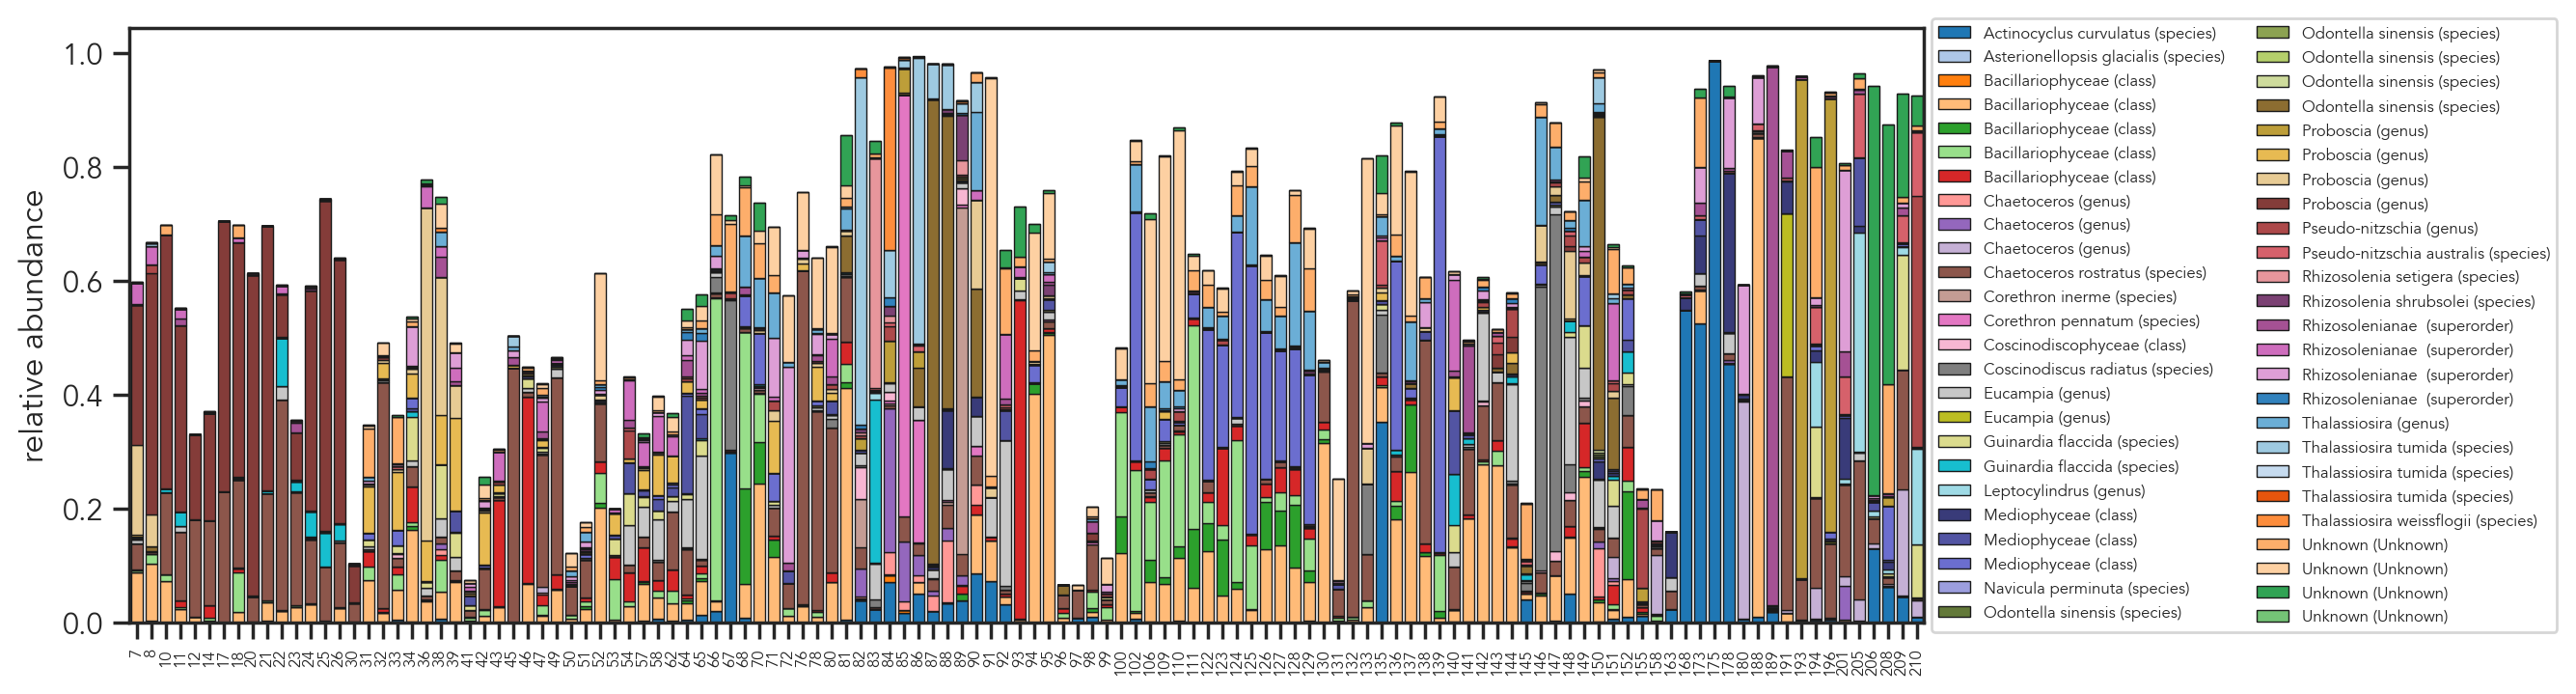

In [21]:
# sort rows by increasing total counts 
counts = Abundances.loc[Abundances.sum(axis=1).sort_values(ascending=False).index]
total = counts[counts>1].sum(axis=0)
columns = [c for c in counts.columns if c[-3:]=='SRF']
# sort columns by name
columns = np.sort(columns)
counts = counts.loc[topID_metaB_key.index, columns]
relative_counts = counts/total[columns]
# rename columns removing _SRF and also the 0 in front of the station number
relative_counts.columns = [c.split('_')[0] for c in relative_counts.columns]
relative_counts.columns = relative_counts.columns.str.replace(r'^0+', '', regex=True)

#relative_counts.columns = relative_counts.columns.str.replace('0','')
# rename the index using the column taxon of the topID_metaB_key, replacing NaN with 'Unknown'
relative_counts.index = topID_metaB_key['taxon'].fillna('Unknown') + ' (' + topID_metaB_key['level'].fillna('Unknown') + ')'

# sort the rows by decreasing total counts
#relative_counts = relative_counts.loc[relative_counts.sum(axis=1).sort_values(ascending=False).index]

colors = sns.color_palette('tab20', n_colors=len(relative_counts))

colors = sns.color_palette('tab20', n_colors=20)
colors += sns.color_palette('tab20b', n_colors=20)
colors += sns.color_palette('tab20c', n_colors=10)

base_palette = sns.color_palette("deep6", n_colors=8)  # Start with 10 color-blind friendly colors

# Step 2: Extend the palette by interpolating
def extend_palette(palette, n_colors):
    colors = []
    for i in range(n_colors):
        idx = i / n_colors * (len(palette) - 1)
        lower = int(np.floor(idx))
        upper = int(np.ceil(idx))
        weight = idx - lower
        color = np.add(np.multiply(1 - weight, palette[lower]), np.multiply(weight, palette[upper]))
        colors.append(tuple(color))
    return colors

# Generate a palette of 50 distinguishable colors
#colors = extend_palette(base_palette, 50)
# shuffle the colors

fig, ax = plt.subplots(1,1,figsize=(12,4))
# make a stacked bar chart where the x-axis are the columns, and the y-axis are the rows
# the height of each bar is the abundance of the OTU in that station
for i in range(len(relative_counts))[:]:
    ax.bar(np.arange(len(relative_counts.columns)), relative_counts.iloc[i], bottom=relative_counts.iloc[:i].sum(), color=colors[i], alpha=1, label=relative_counts.index[i], edgecolor='k', lw=0.5)
    
ax.set_xticks(np.arange(len(relative_counts.columns)))
ax.set_xticklabels(relative_counts.columns, rotation=90, fontsize=6)
ax.set_xlim(-0.5, len(relative_counts.columns)-0.5)
ax.set_ylabel('relative abundance')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=6)

figname = 'relative_abundance_stacked_bar_chart'
fig.savefig(fig_dir+figname+'.pdf', bbox_inches='tight')

In [16]:
import matplotlib.patches as mpatches
import textwrap

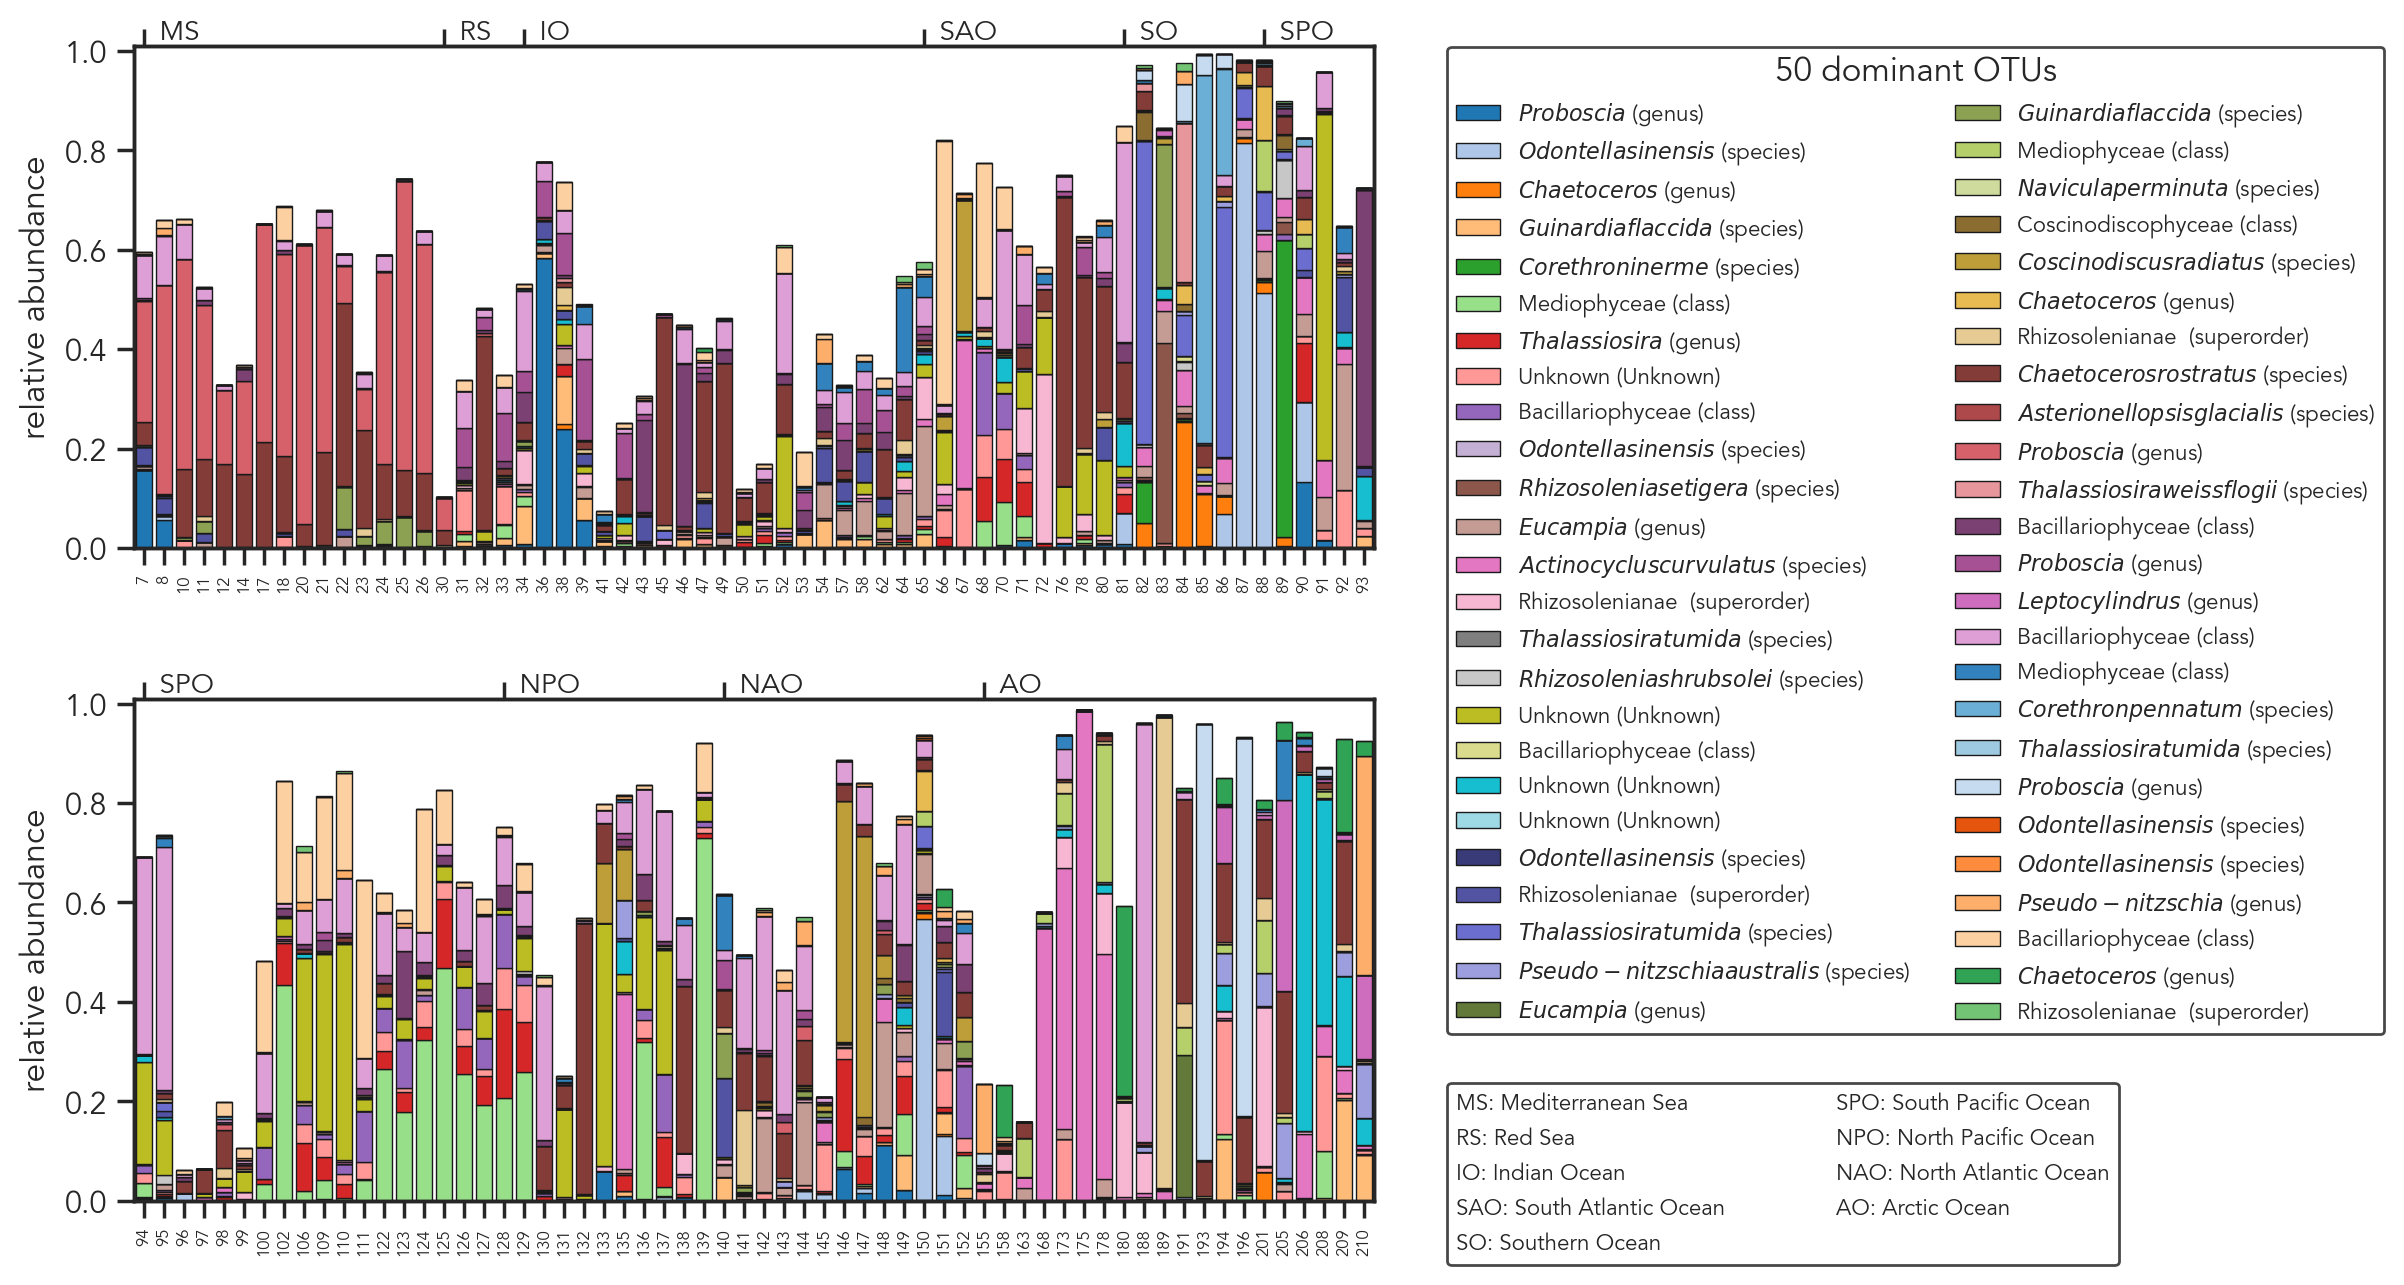

In [19]:
# sort rows by increasing total counts 
counts = Abundances#.loc[Abundances.sum(axis=1).sort_values(ascending=False).index]
total = counts[counts>1].sum(axis=0)
columns = [c for c in counts.columns if c[-3:]=='SRF']
# sort columns by name
columns = np.sort(columns)
counts = counts.loc[:, columns]
relative_counts = counts/counts.sum()
relative_counts = relative_counts.loc[topID_metaB_key.index, columns]
# rename columns removing _SRF and also the 0 in front of the station number
relative_counts.columns = [c.split('_')[0] for c in relative_counts.columns]
relative_counts.columns = relative_counts.columns.str.replace(r'^0+', '', regex=True)

#relative_counts.columns = relative_counts.columns.str.replace('0','')
# rename the index using the column taxon of the topID_metaB_key, replacing NaN with 'Unknown'
relative_counts.index = topID_metaB_key['taxon'].fillna('Unknown') + ' (' + topID_metaB_key['level'].fillna('Unknown') + ')'
# sort index in alphabetical order
#relative_counts = relative_counts.loc[relative_counts.index.sort_values()]

# sort the rows by decreasing total counts
#relative_counts = relative_counts.loc[relative_counts.sum(axis=1).sort_values(ascending=False).index]

colors = sns.color_palette('tab20', n_colors=len(relative_counts))

colors = sns.color_palette('tab20', n_colors=20)
colors += sns.color_palette('tab20b', n_colors=20)
colors += sns.color_palette('tab20c', n_colors=10)

fig, axes = plt.subplots(2,1,figsize=(8,7.5))
fig.subplots_adjust(hspace=0.3)
# make a stacked bar chart where the x-axis are the columns, and the y-axis are the rows
# the height of each bar is the abundance of the OTU in that station

for i in range(len(relative_counts))[:]:
    label = relative_counts.index[i]
    # if label end with (species) or (genus) transform it to italic
    if (label[-7:] == '(genus)'):
        label = r"$" + label[:-7] + "$" + ' (genus)'
    elif (label[-9:] == '(species)'):
        label = r"$" + label[:-9] + "$" + ' (species)'

    axes[0].bar(np.arange(len(relative_counts.columns)//2), relative_counts.iloc[i, :len(relative_counts.columns)//2], bottom=relative_counts.iloc[:i, :len(relative_counts.columns)//2].sum(), color=colors[i], alpha=1, label=label, edgecolor='k', lw=0.5)
    axes[1].bar(np.arange(len(relative_counts.columns)//2), relative_counts.iloc[i, len(relative_counts.columns)//2:], bottom=relative_counts.iloc[:i, len(relative_counts.columns)//2:].sum(), color=colors[i], alpha=1, edgecolor='k', lw=0.5)


axes[0].set_xticks(np.arange(len(relative_counts.columns)//2))
xtick_labels = relative_counts.columns[:len(relative_counts.columns)//2]
axes[0].set_xticklabels(xtick_labels, rotation=90, fontsize=6)
axes[0].set_xlim(-0.5, len(relative_counts.columns)//2-0.5)
axes[0].set_ylim(0, 1.01)
axes[0].set_ylabel('relative abundance')
axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1.02), ncol=2, fontsize=8, title='50 dominant OTUs', frameon=True)
# set the frame color of the legend
axes[0].get_legend().get_frame().set_edgecolor('k')

axes[1].set_xticks(np.arange(len(relative_counts.columns)//2))
xtick_labels = relative_counts.columns[len(relative_counts.columns)//2:]
axes[1].set_xticklabels(xtick_labels, rotation=90, fontsize=6)
axes[1].set_xlim(-0.5, len(relative_counts.columns)//2-0.5)
axes[1].set_ylim(0, 1.01)
axes[1].set_ylabel('relative abundance')
  

ax_top = axes[0].twiny()
ax_top.set_xlim(axes[0].get_xlim()) 
xticks = [0, 15, 19, 39, 49, 56, ]
xticks_labels = ['  MS', '  RS', '  IO', '  SAO', '  SO', '  SPO']
ax_top.set_xticks(xticks)
ax_top.set_xticklabels(xticks_labels, fontsize=10, ha='left', va='top')

ax_top = axes[1].twiny()
ax_top.set_xlim(axes[1].get_xlim()) 
xticks = [0, 18, 29, 42]
xticks_labels = ['  SPO', '  NPO', '  NAO', '  AO']
ax_top.set_xticks(xticks)
ax_top.set_xticklabels(xticks_labels, fontsize=10, ha='left', va='top')

ocean_acronyms = ['MS', 'RS', 'IO', 'SAO', 'SO', 'SPO', 'NPO', 'NAO', 'AO']
ocean_names = [
    'Mediterranean Sea', 'Red Sea', 'Indian Ocean', 
    'South Atlantic Ocean', 'Southern Ocean', 
    'South Pacific Ocean', 'North Pacific Ocean', 'North Atlantic Ocean',
    'Arctic Ocean'
]


# Combine acronyms and names
legend_items = [f"{acronym}: {name}" for acronym, name in zip(ocean_acronyms, ocean_names)]

# Split into two columns
columns = 2
mid = len(legend_items) // columns
col1 = legend_items[:mid]
col2 = legend_items[mid:]

# Create fake legend entries for each column
handles = [plt.Line2D([0], [0], color='white', label=item) for item in col1 + col2]

# Add the fake legend to axes[1]
legend = axes[1].legend(
    handles=handles, loc='lower left', frameon=True, fontsize=8, #title='ocean basins', title_fontsize=12, 
    ncol=2, handlelength=0, handletextpad=0, bbox_to_anchor=(1.05, -0.15), columnspacing=5
)

# Align legend text
for text in legend.get_texts():
    text.set_ha("left")
    
axes[1].get_legend().get_frame().set_edgecolor('k')


figname = 'OTU_abundance_stacked_bar_chart'
fig.savefig(fig_dir+figname+'.png', bbox_inches='tight', dpi=300)

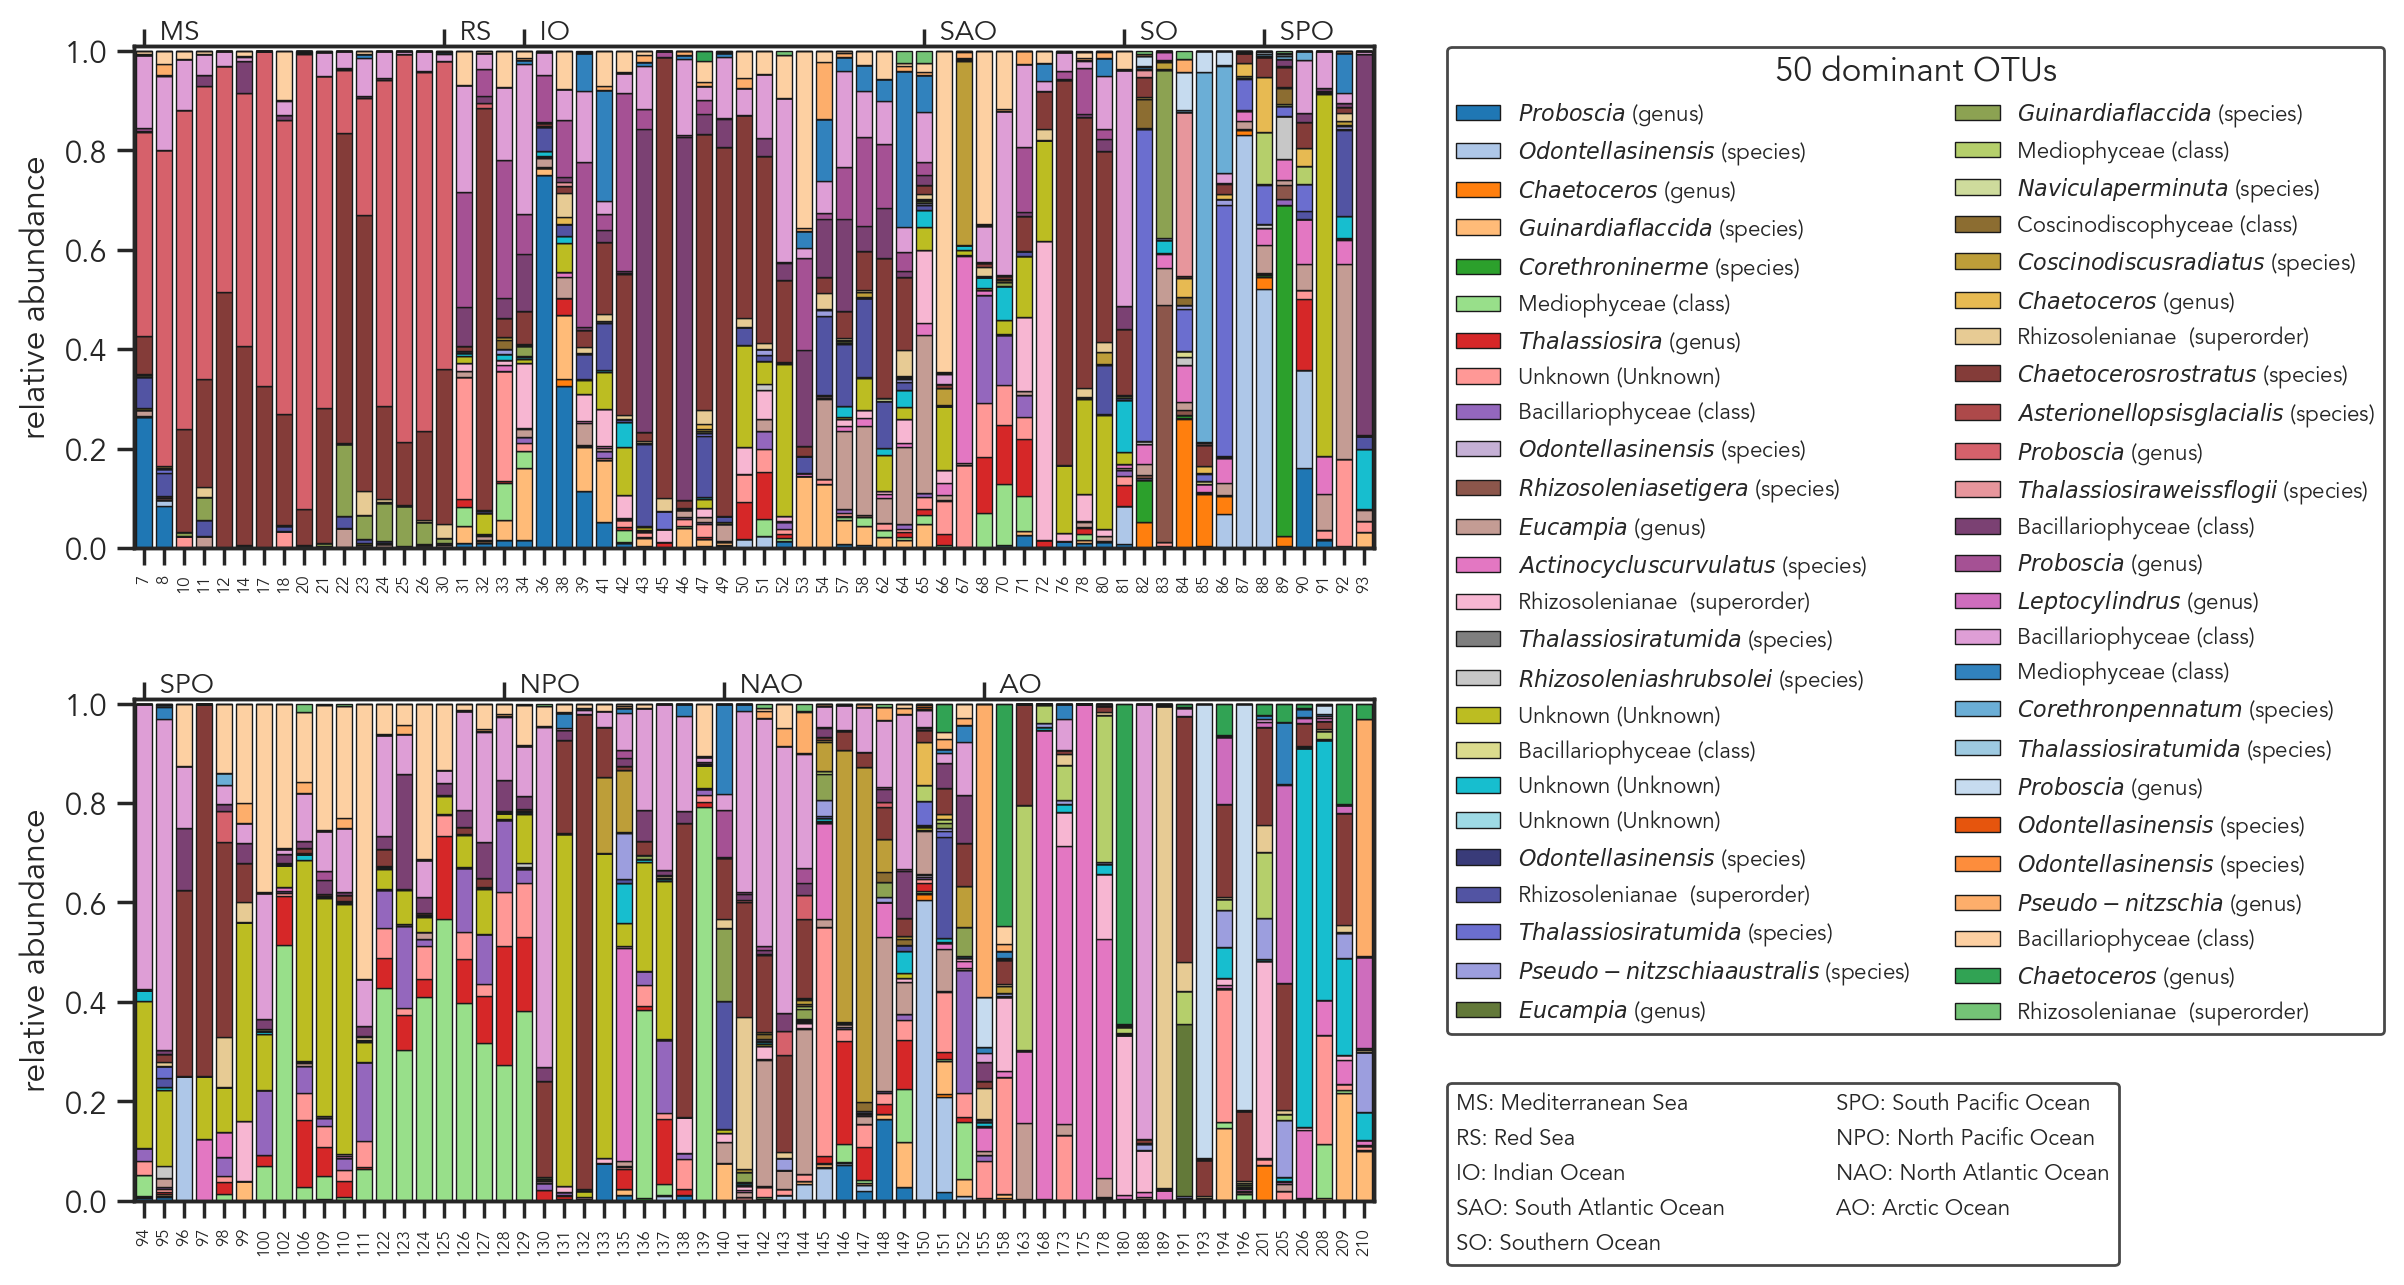

In [20]:
# sort rows by increasing total counts 
counts = Abundances#.loc[Abundances.sum(axis=1).sort_values(ascending=False).index]
total = counts[counts>1].sum(axis=0)
columns = [c for c in counts.columns if c[-3:]=='SRF']
# sort columns by name
columns = np.sort(columns)
counts = counts.loc[topID_metaB_key.index, columns]
relative_counts = counts/counts.sum()
# rename columns removing _SRF and also the 0 in front of the station number
relative_counts.columns = [c.split('_')[0] for c in relative_counts.columns]
relative_counts.columns = relative_counts.columns.str.replace(r'^0+', '', regex=True)

#relative_counts.columns = relative_counts.columns.str.replace('0','')
# rename the index using the column taxon of the topID_metaB_key, replacing NaN with 'Unknown'
relative_counts.index = topID_metaB_key['taxon'].fillna('Unknown') + ' (' + topID_metaB_key['level'].fillna('Unknown') + ')'
# sort index in alphabetical order
#relative_counts = relative_counts.loc[relative_counts.index.sort_values()]

# sort the rows by decreasing total counts
#relative_counts = relative_counts.loc[relative_counts.sum(axis=1).sort_values(ascending=False).index]

colors = sns.color_palette('tab20', n_colors=len(relative_counts))

colors = sns.color_palette('tab20', n_colors=20)
colors += sns.color_palette('tab20b', n_colors=20)
colors += sns.color_palette('tab20c', n_colors=10)

fig, axes = plt.subplots(2,1,figsize=(8,7.5))
fig.subplots_adjust(hspace=0.3)
# make a stacked bar chart where the x-axis are the columns, and the y-axis are the rows
# the height of each bar is the abundance of the OTU in that station

for i in range(len(relative_counts))[:]:
    label = relative_counts.index[i]
    # if label end with (species) or (genus) transform it to italic
    if (label[-7:] == '(genus)'):
        label = r"$" + label[:-7] + "$" + ' (genus)'
    elif (label[-9:] == '(species)'):
        label = r"$" + label[:-9] + "$" + ' (species)'

    axes[0].bar(np.arange(len(relative_counts.columns)//2), relative_counts.iloc[i, :len(relative_counts.columns)//2], bottom=relative_counts.iloc[:i, :len(relative_counts.columns)//2].sum(), color=colors[i], alpha=1, label=label, edgecolor='k', lw=0.5)
    axes[1].bar(np.arange(len(relative_counts.columns)//2), relative_counts.iloc[i, len(relative_counts.columns)//2:], bottom=relative_counts.iloc[:i, len(relative_counts.columns)//2:].sum(), color=colors[i], alpha=1, edgecolor='k', lw=0.5)


axes[0].set_xticks(np.arange(len(relative_counts.columns)//2))
xtick_labels = relative_counts.columns[:len(relative_counts.columns)//2]
axes[0].set_xticklabels(xtick_labels, rotation=90, fontsize=6)
axes[0].set_xlim(-0.5, len(relative_counts.columns)//2-0.5)
axes[0].set_ylim(0, 1.01)
axes[0].set_ylabel('relative abundance')
axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1.02), ncol=2, fontsize=8, title='50 dominant OTUs', frameon=True)
# set the frame color of the legend
axes[0].get_legend().get_frame().set_edgecolor('k')

axes[1].set_xticks(np.arange(len(relative_counts.columns)//2))
xtick_labels = relative_counts.columns[len(relative_counts.columns)//2:]
axes[1].set_xticklabels(xtick_labels, rotation=90, fontsize=6)
axes[1].set_xlim(-0.5, len(relative_counts.columns)//2-0.5)
axes[1].set_ylim(0, 1.01)
axes[1].set_ylabel('relative abundance')
  

ax_top = axes[0].twiny()
ax_top.set_xlim(axes[0].get_xlim()) 
xticks = [0, 15, 19, 39, 49, 56, ]
xticks_labels = ['  MS', '  RS', '  IO', '  SAO', '  SO', '  SPO']
ax_top.set_xticks(xticks)
ax_top.set_xticklabels(xticks_labels, fontsize=10, ha='left', va='top')

ax_top = axes[1].twiny()
ax_top.set_xlim(axes[1].get_xlim()) 
xticks = [0, 18, 29, 42]
xticks_labels = ['  SPO', '  NPO', '  NAO', '  AO']
ax_top.set_xticks(xticks)
ax_top.set_xticklabels(xticks_labels, fontsize=10, ha='left', va='top')

ocean_acronyms = ['MS', 'RS', 'IO', 'SAO', 'SO', 'SPO', 'NPO', 'NAO', 'AO']
ocean_names = [
    'Mediterranean Sea', 'Red Sea', 'Indian Ocean', 
    'South Atlantic Ocean', 'Southern Ocean', 
    'South Pacific Ocean', 'North Pacific Ocean', 'North Atlantic Ocean',
    'Arctic Ocean'
]


# Combine acronyms and names
legend_items = [f"{acronym}: {name}" for acronym, name in zip(ocean_acronyms, ocean_names)]

# Split into two columns
columns = 2
mid = len(legend_items) // columns
col1 = legend_items[:mid]
col2 = legend_items[mid:]

# Create fake legend entries for each column
handles = [plt.Line2D([0], [0], color='white', label=item) for item in col1 + col2]

# Add the fake legend to axes[1]
legend = axes[1].legend(
    handles=handles, loc='lower left', frameon=True, fontsize=8, #title='ocean basins', title_fontsize=12, 
    ncol=2, handlelength=0, handletextpad=0, bbox_to_anchor=(1.05, -0.15), columnspacing=5
)

# Align legend text
for text in legend.get_texts():
    text.set_ha("left")
    
axes[1].get_legend().get_frame().set_edgecolor('k')


figname = 'OTU_relative_abundance_stacked_bar_chart'
fig.savefig(fig_dir+figname+'.png', bbox_inches='tight', dpi=300)

In [31]:
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.html'] = True

## Bray-Curtis dissimilarity

In [21]:
# compute the Bray-Curtis dissimilarity matrix from the matrix of relative counts, where the columns are the stations and the rows are the OTUs
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

# compute the Bray-Curtis dissimilarity matrix
dissimilarity_matrix = pdist(relative_counts.T, metric='braycurtis')
dissimilarity_matrix = squareform(dissimilarity_matrix)
dissimilarity_matrix = pd.DataFrame(dissimilarity_matrix, index=relative_counts.columns, columns=relative_counts.columns)

# plot the Bray-Curtis dissimilarity matrix


In [22]:
paletteTGB = ['#4caf50', '#504B43', '#948d99']
metaTcolor, metaGcolor, metaBcolor = paletteTGB

/var/folders/5p/ph5sykpj0cv_7lj14vw3f84h0000gn/T/ipykernel_96572/2429548941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=fontsize)


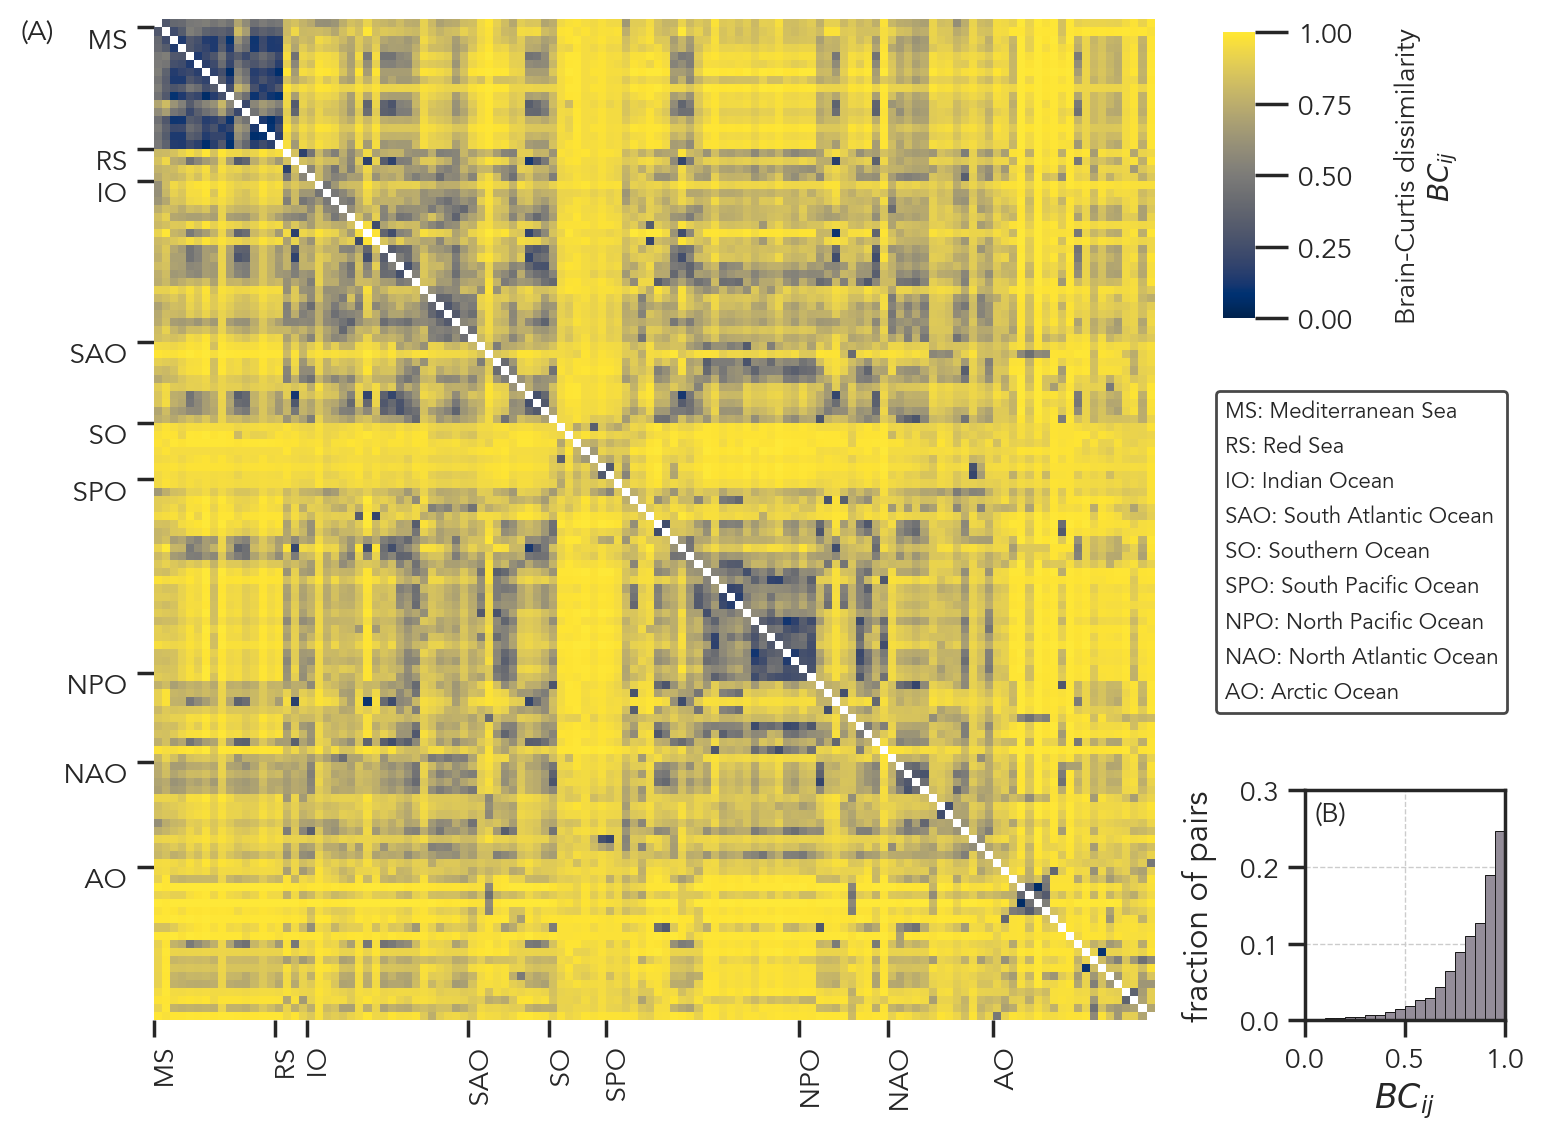

In [24]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
fontsize = 10
ax.text(-0.1, 1., '(A)', fontsize=fontsize, ha='right', va='top', transform=ax.transAxes)

# text = '(A)'
# ax.text(0.0, 1.1, text, fontsize=fontsize, ha='center', va='top', transform=ax.transAxes)
cmap = 'cividis'

cbar_ax = fig.add_axes([0.95, 0.65, 0.025, 0.22])
mask = np.triu(np.ones_like(dissimilarity_matrix, dtype=bool))
mask = np.diag(np.ones_like(mask[0], dtype=bool))
sns.heatmap(dissimilarity_matrix, ax=ax, cmap=cmap, mask=mask, 
            cbar_ax=cbar_ax,
            cbar_kws={'shrink': 0.35, 'pad':0.15, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'neither',
                      'label': r'$BC_{ij}$', 'aspect': 6},
            square=True,
            vmin=0, vmax=1)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fontsize+2, size=fontsize+2)
# change the rotation of the labels
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=fontsize)
label = "Brain-Curtis dissimilarity\n"
label += r"$BC_{ij}$"
cbar.ax.set_ylabel(label, fontsize=fontsize, labelpad=15, rotation=90)

xticks = [0, 15, 19, 39, 49, 56, 62+18, 62+29, 62+42]
yticks = [x+1 for x in xticks]
xticks_labels = ['  MS', '  RS', '  IO', '  SAO', '  SO', '  SPO',  '  NPO', '  NAO', '  AO']

ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels, fontsize=10, ha='left', va='top')
ax.set_yticks(yticks)
ax.set_yticklabels(xticks_labels, fontsize=10, ha='right', va='top')

ocean_acronyms = ['MS', 'RS', 'IO', 'SAO', 'SO', 'SPO', 'NPO', 'NAO', 'AO']
ocean_names = [
    'Mediterranean Sea', 'Red Sea', 'Indian Ocean', 
    'South Atlantic Ocean', 'Southern Ocean', 
    'South Pacific Ocean', 'North Pacific Ocean', 'North Atlantic Ocean',
    'Arctic Ocean'
]


# Combine acronyms and names
legend_items = [f"{acronym}: {name}" for acronym, name in zip(ocean_acronyms, ocean_names)]

# Split into two columns
columns = 2
mid = len(legend_items) // columns
col1 = legend_items[:mid]
col2 = legend_items[mid:]

# Create fake legend entries for each column
handles = [plt.Line2D([0], [0], color='white', label=item) for item in col1 + col2]

# Add the fake legend to axes[1]
legend = ax.legend(
    handles=handles, loc='upper left', frameon=True, fontsize=8, #title='ocean basins', title_fontsize=12, 
    ncol=1, handlelength=0, handletextpad=0, bbox_to_anchor=(1.05, 0.64), columnspacing=5
)

# Align legend text
for text in legend.get_texts():
    text.set_ha("left")
    
ax.get_legend().get_frame().set_edgecolor('k')

axin = ax.inset_axes([1.15, 0., 0.2, 0.23])
axin.set_ylabel('fraction of pairs', fontsize=fontsize+2, labelpad=8)
axin.set_xlabel(r'$BC_{ij}$', fontsize=fontsize+2, labelpad=2)
axin.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)
axin.tick_params(axis='both', which='major', labelsize=fontsize)
axin.text(0.05, 0.95, '(B)', fontsize=fontsize, ha='left', va='top', transform=axin.transAxes)
# set xticks and yticks fontsize
axin.set_xlim(0, 1.)
axin.set_ylim(0, 0.3)
values = dissimilarity_matrix.mask(np.triu(np.ones_like(dissimilarity_matrix, dtype=bool))).values
values = values[~np.isnan(values)]
bins = np.arange(0., 1.05, 0.05)

sns.histplot(values, bins=bins, kde=False, color=metaBcolor, ax=axin, stat='probability', alpha=1, edgecolor='k') 

plt.show()
figname = 'Bray_Curtis_dissimilarity_matrix'
for fmt in fig_formats:
    fig.savefig(fig_dir+figname+fmt, bbox_inches='tight', dpi=300)


## SAD 173

bins [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
counts                                   007_SRF  008_SRF  010_SRF  011_SRF  012_SRF  \
md5sum                                                                          
00b5bb3b1cae64e4d2761e16fc91b2cb     1191       44        0        0        0   
039a44f7c456a8d518a656d4bddb3594        0        6        0        0        0   
044e857fc8eb5fd22318010046f420af        0        0        0        0        0   
0dee4375a6cbe9d2a091e451b1a96370        3        0        0        0        0   
14b113961e0805fb5e1bb3b40d828f52        0        0        0        0        0   
14d6921f8bc3cf5beeb7e09e97590b44        0        0        0        0        0   
1a3552c223231f0691e3309b22560e91        0        0        0        0        0   
1dd232dc11ab0be77562507e2cd0e920        4        2        3        1        0   
1e603b319d769d234717b272f9ec8975        0        0        0        0  

/var/folders/5p/ph5sykpj0cv_7lj14vw3f84h0000gn/T/ipykernel_96572/1271516667.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_xticklabels(['{:.0f}%'.format(x*100) for x in [0.6, 0.8, 1.]], fontsize=fontsize-4)
/var/folders/5p/ph5sykpj0cv_7lj14vw3f84h0000gn/T/ipykernel_96572/1271516667.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_yticklabels(['{:.0f}'.format(x) for x in axin.get_yticks()], fontsize=fontsize-4)


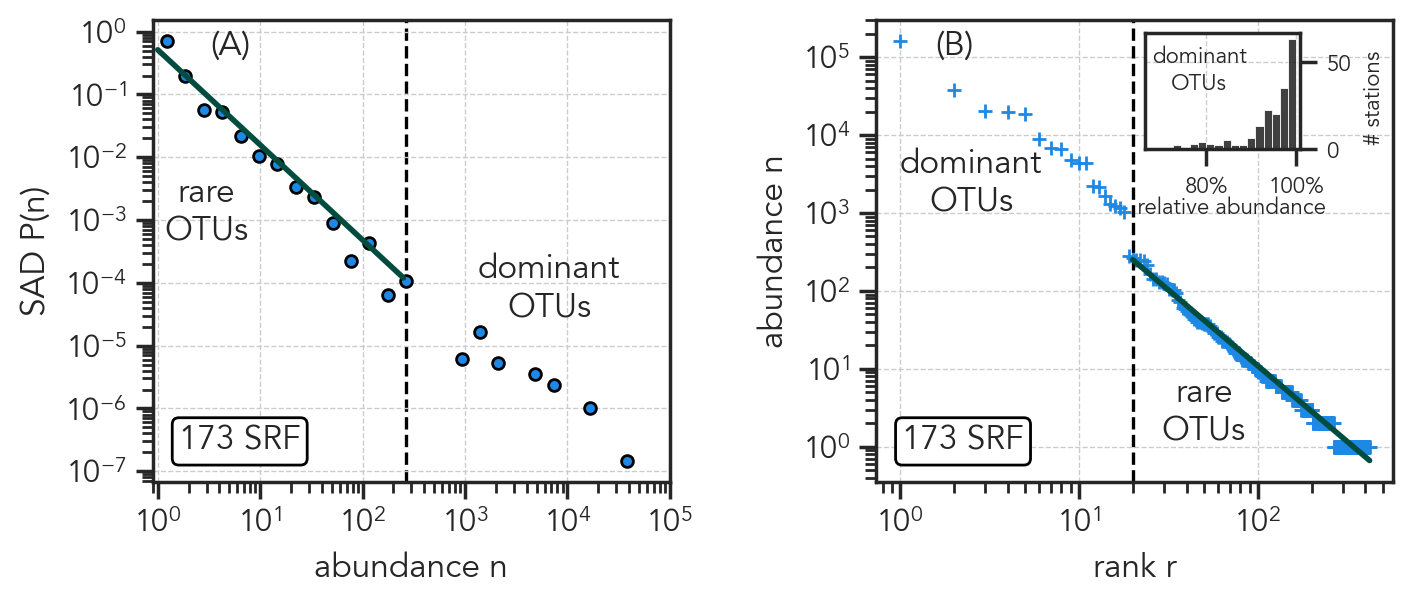

In [26]:
fig, axes = plt.subplots(1,2, figsize=(8,3), sharey=False, sharex=False, constrained_layout=False)
fig.subplots_adjust(wspace=.4)  # Adjust horizontal space between subplots

fontsize = 12

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')


station = 173
depth = 'SRF'
column = str(station)+'_'+depth

#fig.suptitle('Station {} - {}'.format(station, depth), fontsize=fontsize)

data = Abundances[column]
data = data[data>=abundance_thsh]
data = data.sort_values(ascending=False)
rank = np.arange(1,len(data)+1)

bloom_data = data[:number_of_bloomers]
bulk_data = data[number_of_bloomers:]

# SAD 
# bins, counts, prob, pdf = pt.log_hist(data, 30)
print('bins', bins)
print('counts', counts)
x, y = plot_SAD(data, 30)
ax = axes[0]
sns.scatterplot(x=x, y=y, ax=ax, color='#1E88E5', marker='o', edgecolor='black', linewidth=1, s=18)
ax.set_xlabel('abundance n', fontsize=fontsize)
ax.set_ylabel('SAD P(n)', fontsize=fontsize)
ax.yaxis.set_major_locator(tck.LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(tck.LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
ax.yaxis.set_minor_formatter(tck.NullFormatter())  # Remove minor ticks' labels
ax.xaxis.set_major_locator(tck.LogLocator(base=10.0, numticks=10))  # Major ticks
ax.xaxis.set_minor_locator(tck.LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
ax.xaxis.set_minor_formatter(tck.NullFormatter())  # Remove minor ticks' labels

# power-law distribution fit
rho = rho_bulk[column]
x_bulk = np.linspace(np.min(bulk_data), np.max(bulk_data), 100)
label = r'$\rho = {:.2f}$'.format(rho)
y = xmin**(rho)*rho*x_bulk**(-1-rho)
sns.lineplot(x=x_bulk, y=y, ax=ax, color='#004D40', linestyle='-', linewidth=2., label=label)
  
# power-law distribution fit with linear regression
rho_linear = rho_linear_fit[column]
label = r'$\rho = {:.2f}$'.format(rho_linear)
y = xmin**(rho_linear)*rho_linear*x_bulk**(-1-rho_linear)
#sns.lineplot(x=x_bulk, y=y, ax=ax, color='forestgreen', linestyle='--', linewidth=1, label=label)  
  
# reference exponent
rho_ref = 0.5
label = r'$\rho = {:.2f}$'.format(rho_ref)
y = xmin**(rho_ref)*rho_ref*x_bulk**(-1-rho_ref)
#sns.lineplot(x=x_bulk, y=y, ax=ax, color='coral', linestyle='--', linewidth=1, label=label)
ax.legend(fontsize=fontsize)
# remove legend
ax.get_legend().remove() 

# axvlines for bloomers
abundance_of_the_last_bloomer = bloom_data.iloc[-1]
ax.axvline(abundance_of_the_last_bloomer, color='black', linestyle='--', linewidth=1.2, zorder = 0)

ax.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)
ax.set_xticks([1, 10, 100, 1000, 10000, 1e5])
ax.set_xlim(0.9, 1e5)


text = 'rare\nOTUs'
ax.text(3, 5e-3, text, fontsize=fontsize, ha='center', va='top')
text = 'dominant\nOTUs'
ax.text(abundance_of_the_last_bloomer*25, 3e-4, text, fontsize=fontsize, ha='center', va='top')

text = '173 SRF'
ax.text(0.05, 0.05, text, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))






# RAD
ax = axes[1]
ax.yaxis.set_major_locator(tck.LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(tck.LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
ax.yaxis.set_minor_formatter(tck.NullFormatter())  # Remove minor ticks' labels
ax.xaxis.set_major_locator(tck.LogLocator(base=10.0, numticks=10))  # Major ticks
ax.xaxis.set_minor_locator(tck.LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
ax.xaxis.set_minor_formatter(tck.NullFormatter())  # Remove minor ticks' labels
ax.axvline(number_of_bloomers, color='black', linestyle='--', linewidth=1.2)
sns.scatterplot(x=rank, y=data, ax=ax, color='#1E88E5', marker='+', linewidth=1, s=25)
ax.set_xlabel('rank r', fontsize=fontsize)
ax.set_ylabel('abundance n', fontsize=fontsize)
# power-law distribution fit
y = xmin*(rank/(len(data)))**(-1/rho)/1.5
sns.lineplot(x=rank[rank>=number_of_bloomers], y=y[rank>=number_of_bloomers], ax=ax, color='#004D40', linestyle='-', linewidth=2)
# power-law distribution fit with linear regression
y = xmin*(rank/(len(data)))**(-1/rho_linear)
#sns.lineplot(x=rank, y=y, ax=ax, color='forestgreen', linestyle='--', linewidth=1)
# reference exponent
y_ref = xmin*(rank/(len(data)))**(-1/rho_ref)
#sns.lineplot(x=rank, y=y_ref, ax=ax, color='coral', linestyle='--', linewidth=1)

# RAD bulk 
#axin = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
#axin.set_xscale('log')
#axin.set_yscale('log')

rank_bulks = np.arange(1,len(data)-number_of_bloomers+1)
#sns.scatterplot(x=rank_bulks, y=data[number_of_bloomers:], ax=ax, color='black', marker='+', linewidth=1, s=20)
#y_bulks = ((rank_bulks-number_of_bloomers+1)/(len(data)))**(-1/rho)
#sns.lineplot(x=rank_bulks, y=y_bulks, ax=ax, color='firebrick', linestyle='--', linewidth=1)

ax.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)

text = 'rare\nOTUs'
ax.text(50, 8, text, fontsize=fontsize, ha='center', va='top')
text = 'dominant\nOTUs'
ax.text(2.5, 0.7e4, text, fontsize=fontsize, ha='center', va='top')

text = '173 SRF'
ax.text(0.05, 0.05, text, fontsize=fontsize, ha='left', va='bottom', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))


biomass_bloom_values = list(biomass_bloom.values())
biomass_bulks_values = list(biomass_bulk.values())
biomass_bulks_total = np.array(biomass_bulks_values) + np.array(biomass_bloom_values)
relative_biomass_bloom = np.array(biomass_bloom_values)/biomass_bulks_total
relative_biomass_bulk = np.array(biomass_bulks_values)/biomass_bulks_total
axin = ax.inset_axes([0.52, 0.72, 0.3, 0.25])
axin.set_xlim(0.58, 1.01)
sns.histplot(relative_biomass_bloom, ax=axin, bins=15, color='black', kde=False)
axin.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)
# move x ticks to the right
axin.yaxis.set_ticks_position('right')
axin.yaxis.set_label_position('right')
axin.set_xlabel("   relative abundance", fontsize=fontsize-4, labelpad=-1, ha='center')
axin.set_ylabel("# stations  ", fontsize=fontsize-4)
axin.text(0.35, 0.9, 'dominant\nOTUs', fontsize=fontsize-4, ha='center', va='top', transform=axin.transAxes)
axin.set_xticklabels(['{:.0f}%'.format(x*100) for x in [0.6, 0.8, 1.]], fontsize=fontsize-4)
axin.set_yticklabels(['{:.0f}'.format(x) for x in axin.get_yticks()], fontsize=fontsize-4)




text = '(A)'
axes[0].text(0.15, 0.98, text, fontsize=fontsize, ha='center', va='top', transform=axes[0].transAxes)
text = '(B)'
axes[1].text(0.15, 0.98, text, fontsize=fontsize, ha='center', va='top', transform=axes[1].transAxes)

plt.show()
figname = '173_SRF_SAD_RAD.png'
fig.savefig(fig_dir+figname, bbox_inches='tight', dpi=300)


In [ ]:


# station = 205
# depth = 'SRF'
# column = str(station)+'_'+depth

# data = Abundances[column]

# # Data: Assuming these values from the plot
# abundance_classes = np.arange(0, np.log2(data.max())+1, 1)  # log scale classes
# number_of_species = np.histogram(np.log2(data), bins=abundance_classes)[0] # number of species

# # Setting style elements
# plt.style.use('bmh')  # Using a pre-defined style to get a similar aesthetic

# # Set font globally to Times New Roman
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.size'] = 12

# # Create figure and axis objects
# fig, ax = plt.subplots(figsize=(3, 2))
# ax.set_xlim(0,9.5)

# # Create a bar plot
# bars = ax.bar(abundance_classes[1:], number_of_species, color='lightgray', width=0.8, edgecolor='black', linewidth=1.0)


# # polyfit
# x = np.arange(1.15, 10,.1)
# y = 250*x**-1.45
# ax.plot(x,y,"r-")


# # Adding labels and title
# ax.set_xlabel('Abundance classes [log scale]')
# ax.set_ylabel('Number of species')
# # color in rgb is 213, 57, 46
# color = (213./255, 57./255, 46./255)
# # convert to hex

# #ax.set_title('Diatoms', color=color, weight='bold', size=14)

# # Customize ticks
# ax.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', direction='in')

# # white background
# ax.set_facecolor('white')

# # Remove grid
# ax.grid(False)

# # only x and y axis visible in black
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_color('black')

# # increase the space between the title and the plot


# # Show the plot
# plt.show()


[1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00]


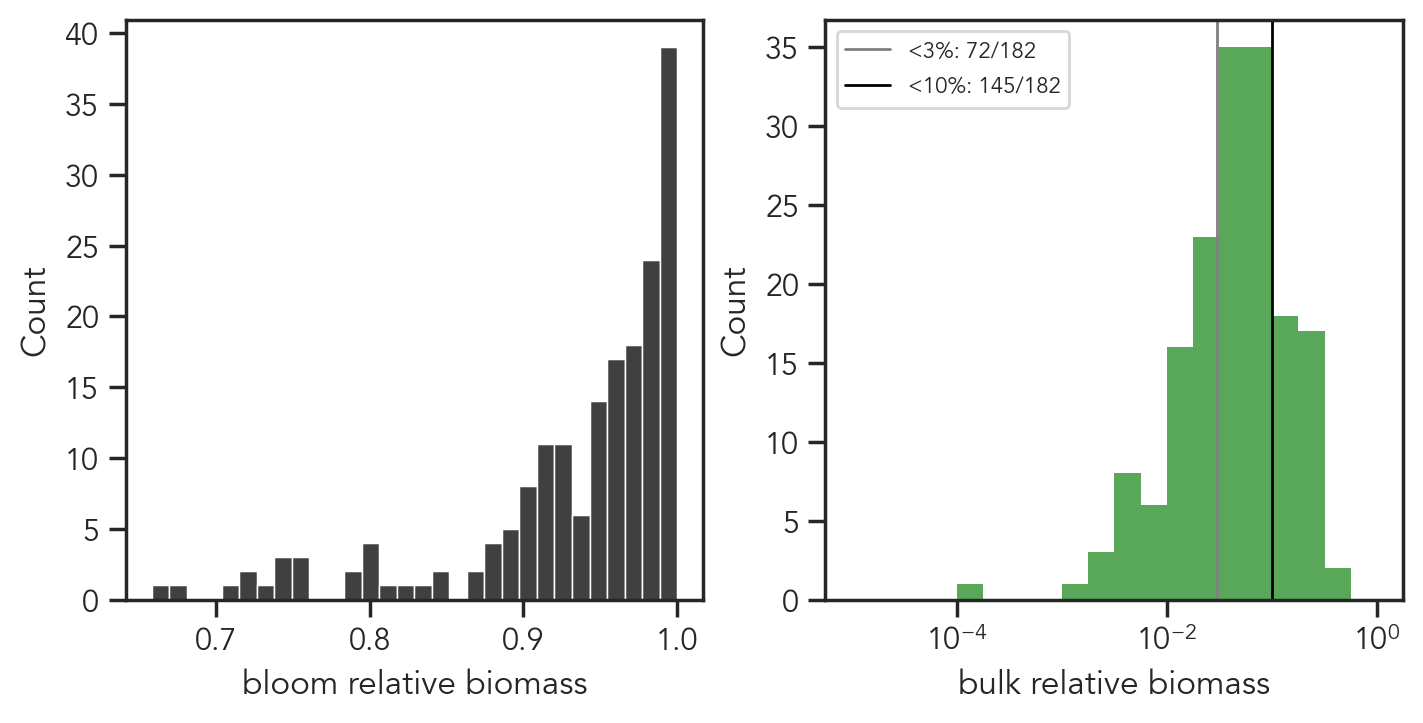

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharey=False, sharex=False, constrained_layout=True)

# biomass distribution of the bloomers
#ax.set_yscale('log')
biomass_bloom_values = list(biomass_bloom.values())
biomass_bulks_values = list(biomass_bulk.values())
biomass_bulks_total = np.array(biomass_bulks_values) + np.array(biomass_bloom_values)
relative_biomass_bloom = np.array(biomass_bloom_values)/biomass_bulks_total
relative_biomass_bulk = np.array(biomass_bulks_values)/biomass_bulks_total

# logspaced bins for the histogram of relative biomass
ax = axes[0]
ax.set_xlabel('bloom relative biomass')
sns.histplot(relative_biomass_bloom, ax=ax, bins=30, color='black', kde=False)
# draw

ax = axes[1]
ax.set_xlabel('bulk relative biomass')
bins = np.logspace(-5,-0,21)
print(bins)
sns.histplot(relative_biomass_bulk, ax=ax, bins=bins, color='forestgreen', edgecolor='k', lw=10)
ax.set_xscale('log')
# label is the number of stations with a relative biomass in the bin less than 1%
label = r'<3%: {}/{}'.format(len(relative_biomass_bulk[relative_biomass_bulk<3e-2]), len(relative_biomass_bulk))
ax.axvline(3e-2, color='grey', linestyle='-', linewidth=1, label=label)
label = r'<10%: {}/{}'.format(len(relative_biomass_bulk[relative_biomass_bulk<1e-1]), len(relative_biomass_bulk))
ax.axvline(1e-1, color='black', linestyle='-', linewidth=1, label=label)
# add a text close to the line with the percentage
ax.legend(fontsize=8)


In [28]:
SRF_gdf = gdf[gdf['depth_category']=='SRF']
DCM_gdf = gdf[gdf['depth_category']=='DCM']

# add the relative biomass to the gdf
SRF_gdf['biomass_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_total'] = SRF_gdf['biomass_bloom'] + SRF_gdf['biomass_bulk']
SRF_gdf['relative_biomass_bloom'] = SRF_gdf['biomass_bloom']/SRF_gdf['biomass_total']
SRF_gdf['relative_biomass_bulk'] = SRF_gdf['biomass_bulk']/SRF_gdf['biomass_total']
SRF_gdf['richness_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['richness_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['richness_total'] = SRF_gdf['richness_bloom'] + SRF_gdf['richness_bulk']

DCM_gdf['biomass_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_total'] = DCM_gdf['biomass_bloom'] + DCM_gdf['biomass_bulk']
DCM_gdf['relative_biomass_bloom'] = DCM_gdf['biomass_bloom']/DCM_gdf['biomass_total']
DCM_gdf['relative_biomass_bulk'] = DCM_gdf['biomass_bulk']/DCM_gdf['biomass_total']
DCM_gdf['richness_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['richness_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['richness_total'] = DCM_gdf['richness_bloom'] + DCM_gdf['richness_bulk']


bloom_thsh = 1e-2
richness_thsh = 1

SRF_gdf['bloom'] = ((SRF_gdf['relative_biomass_bulk']<bloom_thsh) & (SRF_gdf['richness_total']>richness_thsh))
DCM_gdf['bloom'] = ((DCM_gdf['relative_biomass_bulk']<bloom_thsh) & (DCM_gdf['richness_total']>richness_thsh))

# classes 
# if the relative biomass of the bloom is less than 10% and the richness is >50, it is a hyperdominated
# if the relative biomass of the bloom is less than 10% and the richness is <50, it is a poor
# if the relative biomass of the bloom is more than 10% it is non-bloom
bloom_thsh = 2e-2
richness_thsh = 50
SRF_gdf['classes'] = SRF_gdf.apply(lambda x: 'species-rich,\nhyperdominated' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']>richness_thsh else 'species-poor' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']<richness_thsh else 'intermediate', axis=1)
SRF_gdf['classes'] = SRF_gdf['classes'].astype('category')

SRF_gdf.tail()

station  latitude  longitude depth_category  depth_nominal  month    SSD  \
129      205   72.4693   -71.8920            SRF              5     10  584.5   
130      206   70.9618   -53.6030            SRF              5     10  564.5   
131      208   69.1136   -51.5086            SRF              5     10  508.0   
132      209   64.7127   -53.0106            SRF              5     10  531.5   
133      210   61.5442   -55.9865            SRF              5     10  535.0   

     temp_woa    sal_woa   no3_woa  ...  biomass_bloom  biomass_bulk  \
129  -0.89261  31.219290  1.793274  ...      1548303.0        9845.0   
130   2.43763  32.896900  1.785118  ...       359106.0        5592.0   
131   2.93860  33.131413  1.630793  ...        26499.0        1271.0   
132   2.51751  32.442013  3.216127  ...       234758.0        6234.0   
133   5.20301  33.989799  3.419286  ...        69382.0        1512.0   

     biomass_total  relative_biomass_bloom  relative_biomass_bulk  \
129      1558148.0                0.993682               0.006318   
130       364698.0                0.984667               0.015333   
131        27770.0                0.954231               0.045769   
132       240992.0                0.974132               0.025868   
133        70894.0                0.978672               0.021328   

     richness_bloom richness_bulk  richness_total  bloom  \
129            20.0         330.0           350.0   True   
130            20.0         215.0           235.0  False   
131            20.0          84.0           104.0  False   
132            20.0         255.0           275.0  False   
133            20.0          99.0           119.0  False   

                           classes  
129  species-rich,\nhyperdominated  
130  species-rich,\nhyperdominated  
131                   intermediate  
132                   intermediate  
133                   intermediate  

[5 rows x 27 columns]

In [29]:
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharey=False, sharex=False, constrained_layout=True)
ax = axes[0]
sns.histplot(x='richness_total', hue='classes', data=SRF_gdf, ax=ax, bins=30, kde=False, palette='coolwarm', edgecolor='k')
ax.set_title('SRF')
ax.legend(fontsize=8)


ax = axes[1]
sns.histplot(x='richness_total', data=DCM_gdf, ax=ax, bins=30, kde=False)



/var/folders/5p/ph5sykpj0cv_7lj14vw3f84h0000gn/T/ipykernel_96572/1040671385.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8)


<Axes: xlabel='richness_total', ylabel='Count'>

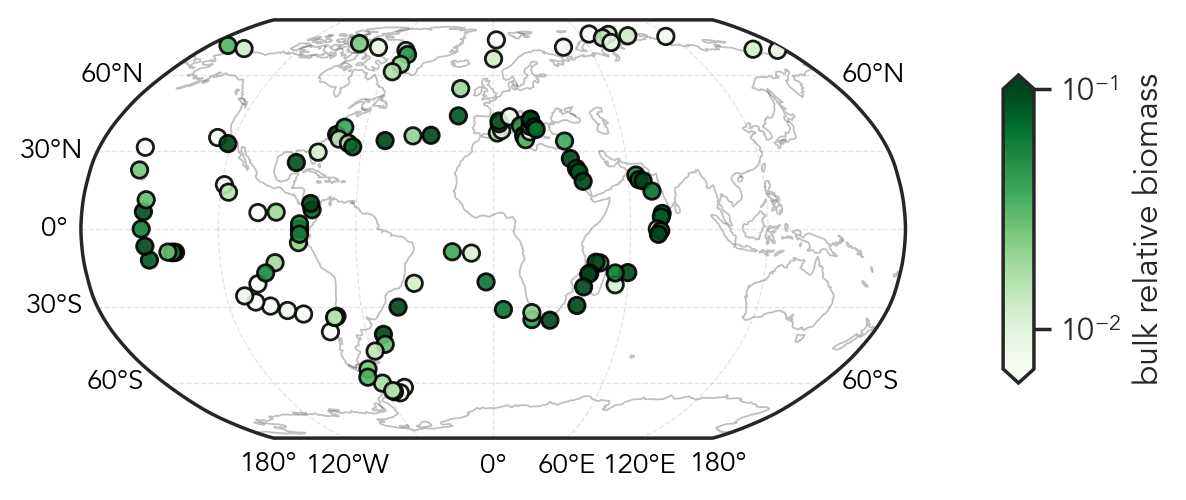

In [30]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "relative_biomass_bulk"
cmap = "Greens"
#cmap = cmocean.cm.balance
vmin, vmax = 1e-3, 1e-1
cbar = SRF_gdf.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=vmin, vmax=vmax,
 norm = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=5*1e-2),
 legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.5, 'pad':0.09, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'bulk relative biomass', 'aspect': 10})

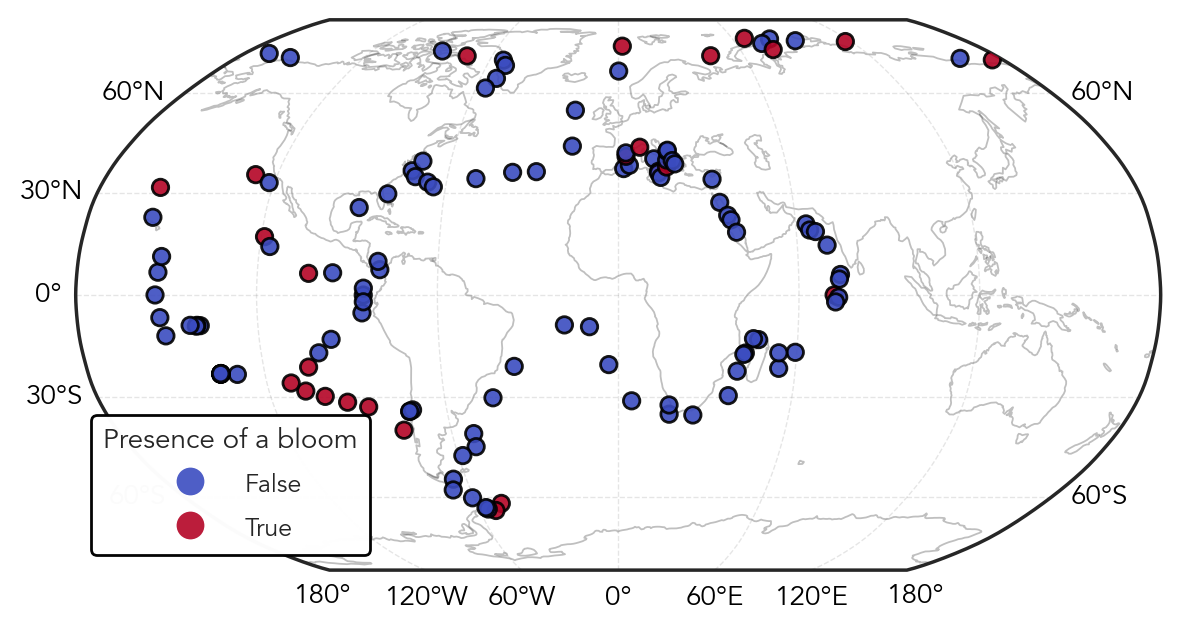

In [31]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False



column = "bloom"

SRF_gdf.plot(column=column, ax=ax, transform = ccrs.Geodetic(), zorder=10, cmap='coolwarm', legend=True, alpha=0.9, lw=1, edgecolors='black', s=35)

legend = ax.get_legend()
legend.set_title('Presence of a bloom', prop={'size': 10})
# set transparency
legend.get_frame().set_alpha(0.99)
legend.get_frame().set_edgecolor('black')

# If you want to change the font size of the labels as well
for label in legend.get_texts():
    label.set_fontsize(9)

In [32]:
import matplotlib.patches as patches

slope species-poor all: 0.227249745389581
slope nan
slope intermediate all: 0.3323956720695311
slope 0.515157693634968
slope species-rich,
hyperdominated all: 0.3302549070682982
slope 0.5512236147346592


/Users/epigani/miniconda3/envs/GenesEnv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/epigani/miniconda3/envs/GenesEnv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/epigani/miniconda3/envs/GenesEnv/lib/python3.13/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/epigani/miniconda3/envs/GenesEnv/lib/python3.13/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start


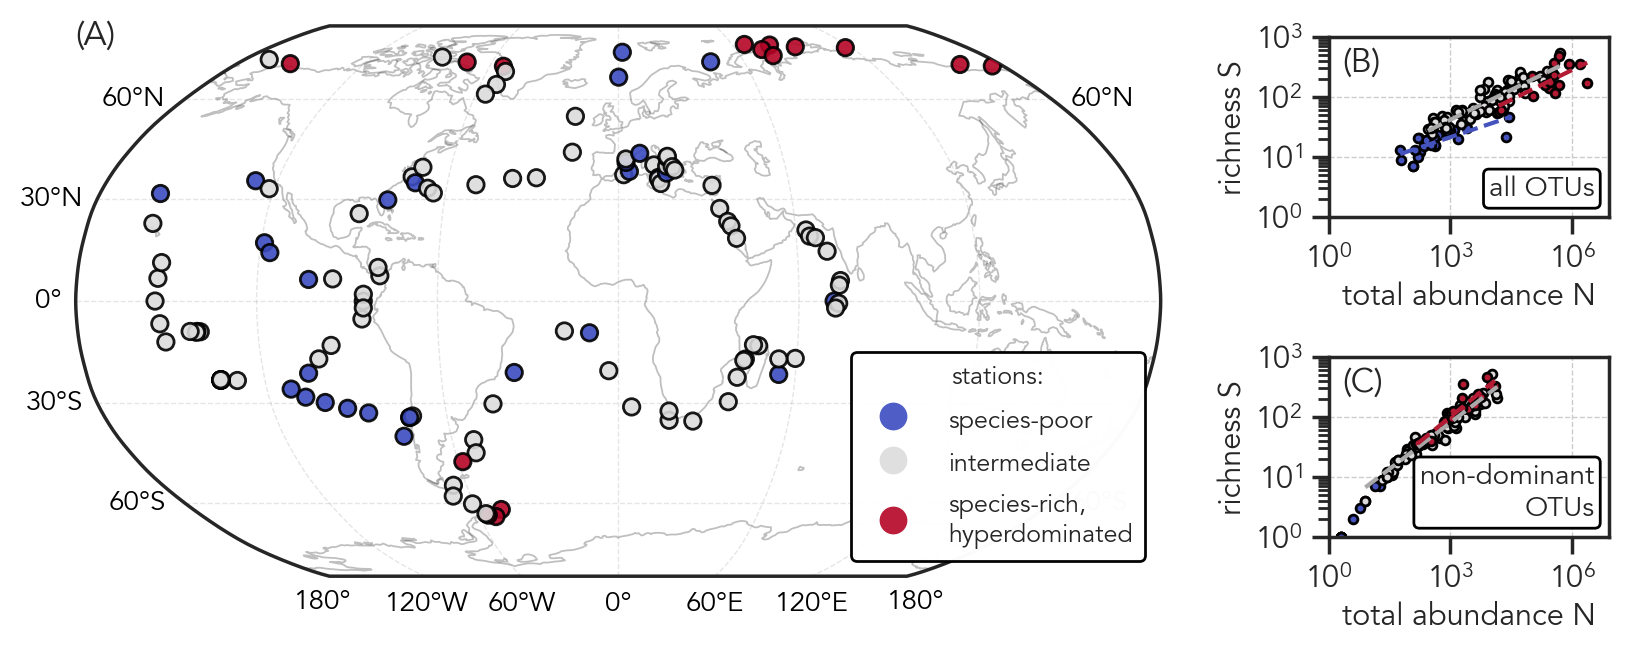

In [33]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))

ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# Add gridlines with labels
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,
    color='gray', alpha=0.2, linestyle='--', zorder=0,
    xlabel_style={'size': 10, 'color': 'black'},
    ylabel_style={'size': 10, 'color': 'black'}
)
gl.top_labels = False
gl.right_labels = False

# Sort by latitude and plot geospatial data
column = "classes"
SRF_gdf.sort_values(by='station', inplace=True)

desired_order = ['species-poor', 'intermediate', 'species-rich,\nhyperdominated']

# Reorder the column in SRF_gdf
SRF_gdf[column] = pd.Categorical(SRF_gdf[column], categories=desired_order, ordered=True)


# Plot with the reordered categories
SRF_gdf.plot(
    column=column, ax=ax, transform=ccrs.Geodetic(), zorder=10,
    cmap='coolwarm', legend=True, alpha=0.9, lw=1,
    edgecolor='black', s=35
)

# Get the legend object and update its properties
legend = ax.get_legend()
if legend is not None:
    legend.set_title('stations:', prop={'size': 9})
    legend.get_frame().set_alpha(0.99)
    legend.get_frame().set_edgecolor('black')
    for label in legend.get_texts():
        label.set_fontsize(9)
        
# get colors from the cmap used with 3 values
colors = sns.color_palette('coolwarm', 3)   
        
ax.text(0.0, 0.95, '(A)', fontsize=12, ha='left', va='bottom', transform=ax.transAxes)

# Create a white rectangle
rect = patches.Rectangle(
    (1, 1),  # Bottom-left corner (x, y)
    5,       # Width
    4,       # Height
    edgecolor='black',  # Border color
    facecolor='white',  # Fill color
    transform=ax.transAxes,  # Coordinate system   
    linewidth=2         # Border thickness
)

# Add the rectangle to the plot
ax.add_patch(rect)
        
ax3 = fig.add_axes([1.02, 0.2, 0.2, 0.225])
ax2 = fig.add_axes([1.02, 0.6, 0.2, 0.225])

for ax in [ax2, ax3]:
    ax.set_ylabel('richness S', fontsize=fontsize-1, labelpad=2)
    ax.set_xlabel('total abundance N', fontsize=fontsize-1, labelpad=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)
    ax.set_xlim(1e0, 8e6)
    ax.set_ylim(1e0, 1e3)
    

rgb_colors = [(69, 83, 191), (220, 218, 218), (179, 27, 52)]
colors = ['#{:02x}{:02x}{:02x}'.format(*rgb_color) for rgb_color in rgb_colors]

for classe, color, rgb_color in zip(desired_order, colors, rgb_colors):
    ax = ax2
    linecolor = color
    data = SRF_gdf.loc[SRF_gdf['classes']==classe]
    sns.scatterplot(x='biomass_total', y='richness_total', data=data, ax=ax, color=color, s=10, edgecolor='black', lw=1)
    # power-law fit for the total
    logx, logy = np.log10(data['biomass_total']), np.log10(data['richness_total'])
    logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
    slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
    x = np.logspace(np.min(logx), np.max(logx), 100)
    y = 10**(intercept)*x**slope
    if rgb_color == (220, 218, 218):
        linecolor = 'darkgrey'
    sns.lineplot(x=x, y=y, ax=ax, color=linecolor, linestyle='--', linewidth=1.5)
    label = '{}: {:.2f}'.format(classe, slope)
    #ax.text(0.5, 0.95, label, fontsize=fontsize-1, ha='center', va='top', transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    print(f"slope {classe} all: {slope}")
    
    ax = ax3
    data = SRF_gdf.loc[SRF_gdf['classes']==classe]
    sns.scatterplot(x='biomass_bulk', y='richness_bulk', data=data, ax=ax, color=color, s=10, edgecolor='black', lw=1)
    # power-law fit for the total
    try:
        logx, logy = np.log10(data['biomass_bulk']), np.log10(data['richness_bulk'])
        logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
        slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
        x = np.logspace(np.min(logx), np.max(logx), 100)
        y = 10**(intercept)*x**slope
        print('slope', slope)
        sns.lineplot(x=x, y=y, ax=ax, color=linecolor, linestyle='--', linewidth=1.5)
    except:
        pass

ax2.text(0.95, 0.08, 'all OTUs', fontsize=fontsize-2, ha='right', va='bottom', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
ax3.text(0.95, 0.08, 'non-dominant\nOTUs', fontsize=fontsize-2, ha='right', va='bottom', transform=ax3.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
ax2.text(0.05, 0.95, '(B)', fontsize=12, ha='left', va='top', transform=ax2.transAxes)
ax3.text(0.05, 0.95, '(C)', fontsize=12, ha='left', va='top', transform=ax3.transAxes)


        
plt.show()
figname = 'Hyperdominated_Heaps.png'
fig.savefig(fig_dir+figname, bbox_inches='tight', dpi=300)

### Heaps Law

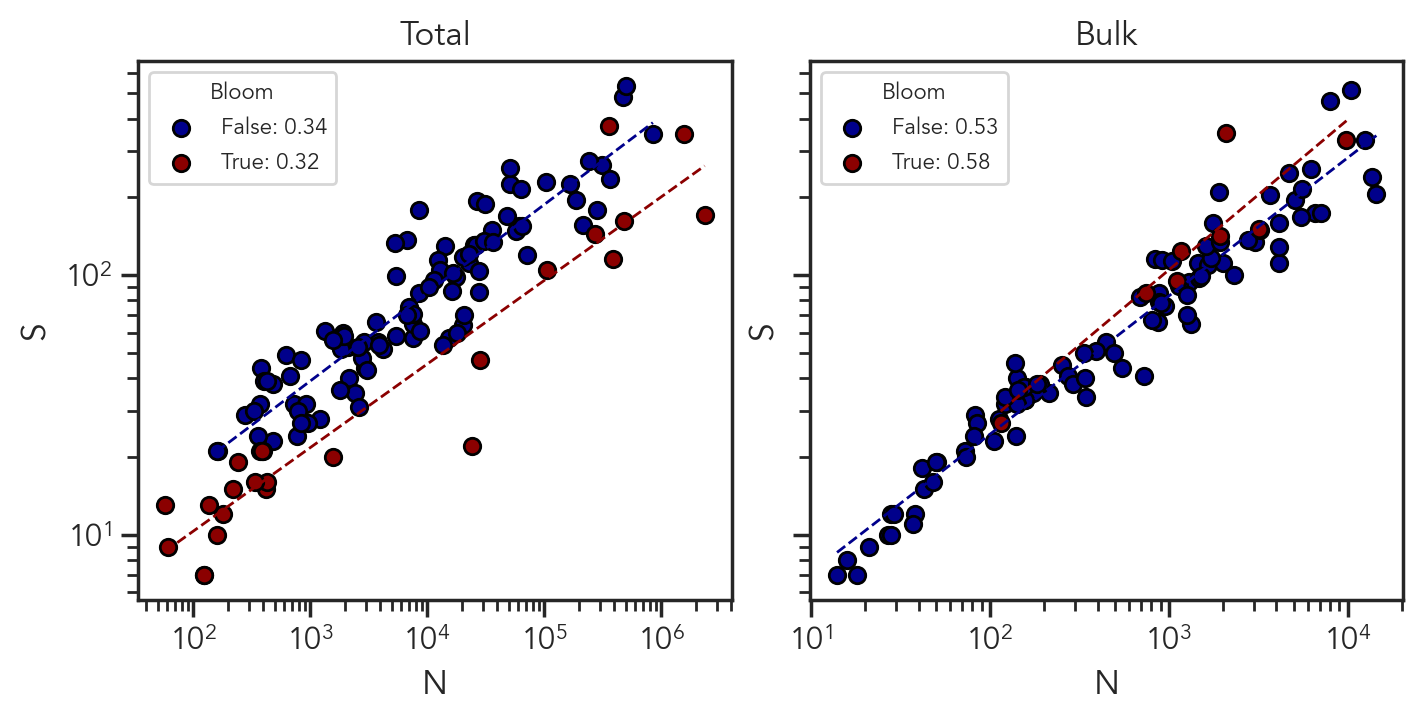

In [34]:
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharey=True, sharex=False, constrained_layout=True)
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('N')
    ax.set_ylabel('S')

# All
ax = axes[0]
ax.set_title('Total')
data = SRF_gdf.loc[SRF_gdf['bloom']==False]
color = 'DarkBlue'
# power-law fit for the total
logx, logy = np.log10(data['biomass_total']), np.log10(data['richness_total'])
logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
x = np.logspace(np.min(logx), np.max(logx), 100)
y = 10**(intercept)*x**slope
sns.lineplot(x=x, y=y, ax=ax, color=color, linestyle='--', linewidth=1)
label = 'False: {:.2f}'.format(slope)
sns.scatterplot(x='biomass_total', y='richness_total', data=data, ax=ax, color=color, s=35, edgecolor='black', lw=1, label=label)

data = SRF_gdf.loc[SRF_gdf['bloom']==True]
color = 'DarkRed'
# power-law fit for the total
logx, logy = np.log10(data['biomass_total']), np.log10(data['richness_total'])
logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
x = np.logspace(np.min(logx), np.max(logx), 100)
y = 10**(intercept)*x**slope
sns.lineplot(x=x, y=y, ax=ax, color=color, linestyle='--', linewidth=1)
label = 'True: {:.2f}'.format(slope)
sns.scatterplot(x='biomass_total', y='richness_total', data=data, ax=ax, color=color, s=35, edgecolor='black', lw=1, label=label)

ax.legend(fontsize=8, title='Bloom', title_fontsize=8)

# Bulk
ax = axes[1]
ax.set_title('Bulk')
data = SRF_gdf.loc[SRF_gdf['bloom']==False]
data = data[data['biomass_bulk']>10]
color = 'DarkBlue'
logx, logy = np.log10(data['biomass_bulk']), np.log10(data['richness_bulk'])
logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
x = np.logspace(np.min(logx), np.max(logx), 100)
y = 10**(intercept)*x**slope
sns.lineplot(x=x, y=y, ax=ax, color=color, linestyle='--', linewidth=1)
label = 'False: {:.2f}'.format(slope)
sns.scatterplot(x='biomass_bulk', y='richness_bulk', data=data, ax=ax, color=color, s=35, edgecolor='black', lw=1, label=label)

data = SRF_gdf.loc[SRF_gdf['bloom']==True]
color = 'DarkRed'
# select data where biomass_bulk is not nan and > 0
data = data[data['biomass_bulk']>10]
logx, logy = np.log10(data['biomass_bulk']), np.log10(data['richness_bulk'])
logx, logy = logx[~np.isnan(logy)], logy[~np.isnan(logy)]
slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
x = np.logspace(np.min(logx), np.max(logx), 100)
y = 10**(intercept)*x**slope
#print(x, y, logx, logy)
sns.lineplot(x=x, y=y, ax=ax, color=color, linestyle='--', linewidth=1)
label = 'True: {:.2f}'.format(slope)
sns.scatterplot(x='biomass_bulk', y='richness_bulk', data=data, ax=ax, color=color, s=35, edgecolor='black', lw=1, label=label)






ax.legend(fontsize=8, title='Bloom', title_fontsize=8)


## metacommunity index

In [35]:
SRF_gdf['K_total'] = SRF_gdf['richness_total']/SRF_gdf['biomass_total']**0.5
SRF_gdf['K_bulk'] = SRF_gdf['richness_bulk']/SRF_gdf['biomass_bulk']**0.5

DCM_gdf['K_total'] = DCM_gdf['richness_total']/DCM_gdf['biomass_total']**0.5
DCM_gdf['K_bulk'] = DCM_gdf['richness_bulk']/DCM_gdf['biomass_bulk']**0.5

In [36]:
# print mean, std and cv of K
print('SRF')
print('K_total: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf['K_total'].mean(), SRF_gdf['K_total'].std(), SRF_gdf['K_total'].std()/SRF_gdf['K_total'].mean()))
print('K_bulk: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf['K_bulk'].mean(), SRF_gdf['K_bulk'].std(), SRF_gdf['K_bulk'].std()/SRF_gdf['K_bulk'].mean()))

# print mean, std and cv of K for bloom and non-bloom stations
print('SRF')
print('K_total')
print('Bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].std(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].std()/SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].mean()))
print('Non-bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].std(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].std()/SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].mean()))

print('K_bulk')
print('Bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].std(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].std()/SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].mean()))
print('Non-bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].std(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].std()/SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].mean()))

### DCM

print('DCM')
print('K_total: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf['K_total'].mean(), DCM_gdf['K_total'].std(), DCM_gdf['K_total'].std()/DCM_gdf['K_total'].mean()))
print('K_bulk: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf['K_bulk'].mean(), DCM_gdf['K_bulk'].std(), DCM_gdf['K_bulk'].std()/DCM_gdf['K_bulk'].mean()))

# print mean, std and cv of K for bloom and non-bloom stations
print('DCM')
print('K_total')
print('Bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf.loc[DCM_gdf['bloom']==True,'K_total'].mean(), DCM_gdf.loc[DCM_gdf['bloom']==True,'K_total'].std(), DCM_gdf.loc[DCM_gdf['bloom']==True,'K_total'].std()/DCM_gdf.loc[DCM_gdf['bloom']==True,'K_total'].mean()))
print('Non-bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf.loc[DCM_gdf['bloom']==False,'K_total'].mean(), DCM_gdf.loc[DCM_gdf['bloom']==False,'K_total'].std(), DCM_gdf.loc[DCM_gdf['bloom']==False,'K_total'].std()/DCM_gdf.loc[DCM_gdf['bloom']==False,'K_total'].mean()))

print('K_bulk')
print('Bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf.loc[DCM_gdf['bloom']==True,'K_bulk'].mean(), DCM_gdf.loc[DCM_gdf['bloom']==True,'K_bulk'].std(), DCM_gdf.loc[DCM_gdf['bloom']==True,'K_bulk'].std()/DCM_gdf.loc[DCM_gdf['bloom']==True,'K_bulk'].mean()))
print('Non-bloom: mean {:.2f} std {:.2f} cv {:.2f}'.format(DCM_gdf.loc[DCM_gdf['bloom']==False,'K_bulk'].mean(), DCM_gdf.loc[DCM_gdf['bloom']==False,'K_bulk'].std(), DCM_gdf.loc[DCM_gdf['bloom']==False,'K_bulk'].std()/DCM_gdf.loc[DCM_gdf['bloom']==False,'K_bulk'].mean()))


SRF
K_total: mean 0.92 std 0.44 cv 0.48
K_bulk: mean 2.57 std 0.94 cv 0.37
SRF
K_total
Bloom: mean 0.71 std 0.41 cv 0.58
Non-bloom: mean 0.98 std 0.43 cv 0.44
K_bulk
Bloom: mean 2.68 std 1.95 cv 0.73
Non-bloom: mean 2.56 std 0.75 cv 0.29
DCM
K_total: mean nan std nan cv nan
K_bulk: mean nan std nan cv nan
DCM
K_total
Bloom: mean nan std nan cv nan
Non-bloom: mean nan std nan cv nan
K_bulk
Bloom: mean nan std nan cv nan
Non-bloom: mean nan std nan cv nan


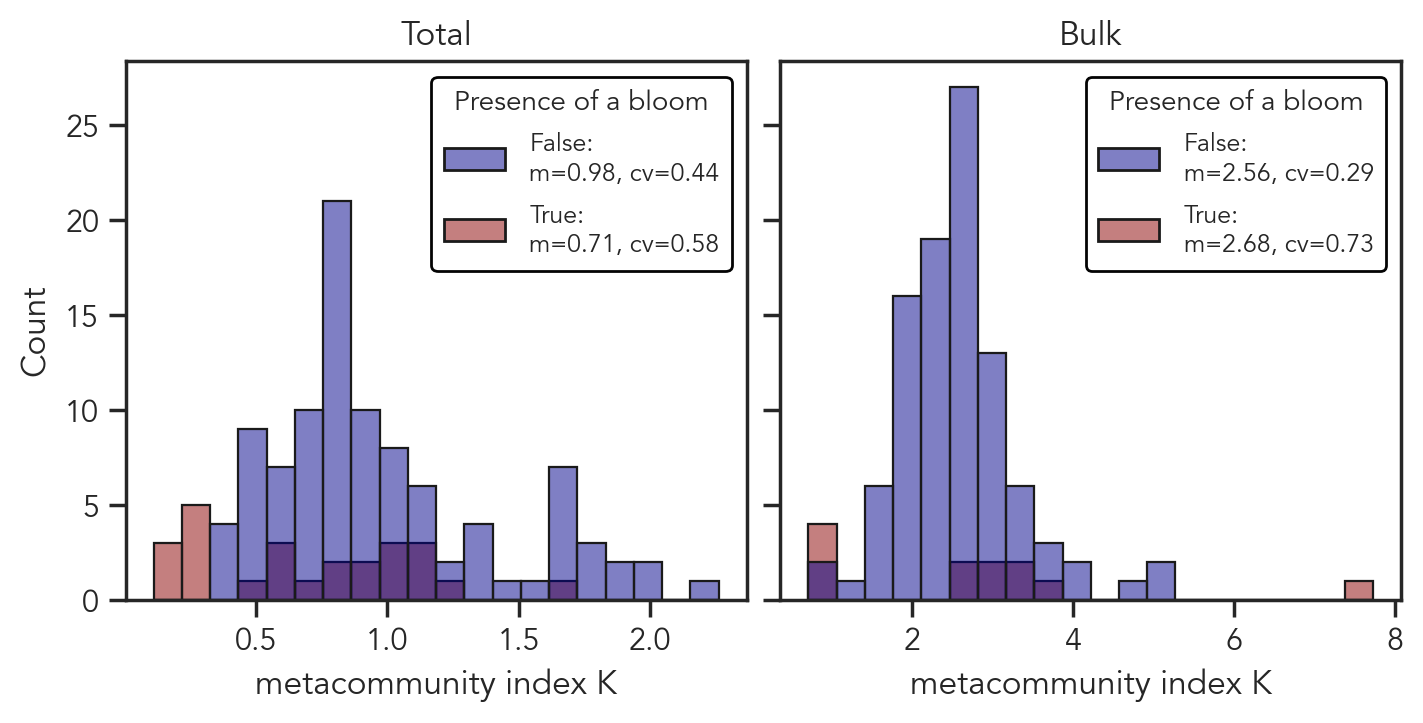

In [37]:
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharey=True, sharex=False, constrained_layout=True)

# custom palette with DarkRed for bloom and DarkBlue for no bloom
palette = sns.color_palette(['DarkBlue', 'DarkRed'])

ax = axes[0]
sns.histplot(x='K_total', data=SRF_gdf, ax=ax, hue='bloom', bins=20, edgecolor='k',  kde=False, stat='count', palette=palette, legend=True)
legend = ax.get_legend()
for i, text in enumerate(legend.get_texts()):
    if i == 0:
        text.set_text('False:\nm={:.2f}, cv={:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].std()/SRF_gdf.loc[SRF_gdf['bloom']==False,'K_total'].mean()))
    else:
        text.set_text('True:\nm={:.2f}, cv={:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].std()/SRF_gdf.loc[SRF_gdf['bloom']==True,'K_total'].mean()))
ax.set_xlabel('metacommunity index K')
ax.set_title('Total')

ax = axes[1]
sns.histplot(x='K_bulk', data=SRF_gdf, ax=ax, hue='bloom', bins=20, edgecolor='k', kde=False, stat='count', palette=palette)
legend = ax.get_legend()
for i, text in enumerate(legend.get_texts()):
    if i == 0:
        text.set_text('False:\nm={:.2f}, cv={:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].std()/SRF_gdf.loc[SRF_gdf['bloom']==False,'K_bulk'].mean()))
    else:
        text.set_text('True:\nm={:.2f}, cv={:.2f}'.format(SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].mean(), SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].std()/SRF_gdf.loc[SRF_gdf['bloom']==True,'K_bulk'].mean()))
ax.set_xlabel('metacommunity index K')
ax.set_title('Bulk')

for ax in axes:
    legend = ax.get_legend()
    legend.set_title('Presence of a bloom', prop={'size': 10})
    # set fontsize
    for label in legend.get_texts():
        label.set_fontsize(9)
    # change the legend to add the mean and the cv of K for bloom and non-bloom stations
    legend.get_frame().set_alpha(0.99)
    legend.get_frame().set_edgecolor('black')

# S = K N**0.5


In [38]:
# build a distance dataframe using the K index
# use the K index for the bulk
d_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

d_log_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_log_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

for i, row in SRF_gdf.iterrows():
    for j, row2 in SRF_gdf.iterrows():
        d_total.loc[row['station'], row2['station']] = (row['K_total']-row2['K_total'])**2
        d_bulk.loc[row['station'], row2['station']] = (row['K_bulk']-row2['K_bulk'])**2
        d_log_total.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_total'])-np.log10(row2['K_total'])))
        d_log_bulk.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_bulk'])-np.log10(row2['K_bulk'])))

# remove nan columns and nan rows
d_total = d_total.dropna(axis=0, how='all')
d_total = d_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_bulk = d_bulk.dropna(axis=0, how='all')
d_bulk = d_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_total = d_log_total.dropna(axis=0, how='all')
d_log_total = d_log_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_bulk = d_log_bulk.dropna(axis=0, how='all')
d_log_bulk = d_log_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')

# sort index and column by bloom status and  by number
sorted_index = SRF_gdf.sort_values(by=['station','bloom'], ascending=False)['station']
# last station with bloom = True
blooms_stations = len(SRF_gdf[SRF_gdf['bloom']==True])
# remove index that are not present in the distance matrix
sorted_index = sorted_index[sorted_index.isin(d_bulk.index)]
print(sorted_index)
d_total = d_total.loc[sorted_index, sorted_index]
d_bulk = d_bulk.loc[sorted_index, sorted_index]
d_log_total = d_log_total.loc[sorted_index, sorted_index]
d_log_bulk = d_log_bulk.loc[sorted_index, sorted_index]



133    210
132    209
131    208
130    206
129    205
      ... 
5       14
4       12
3       11
1        8
0        7
Name: station, Length: 110, dtype: int64


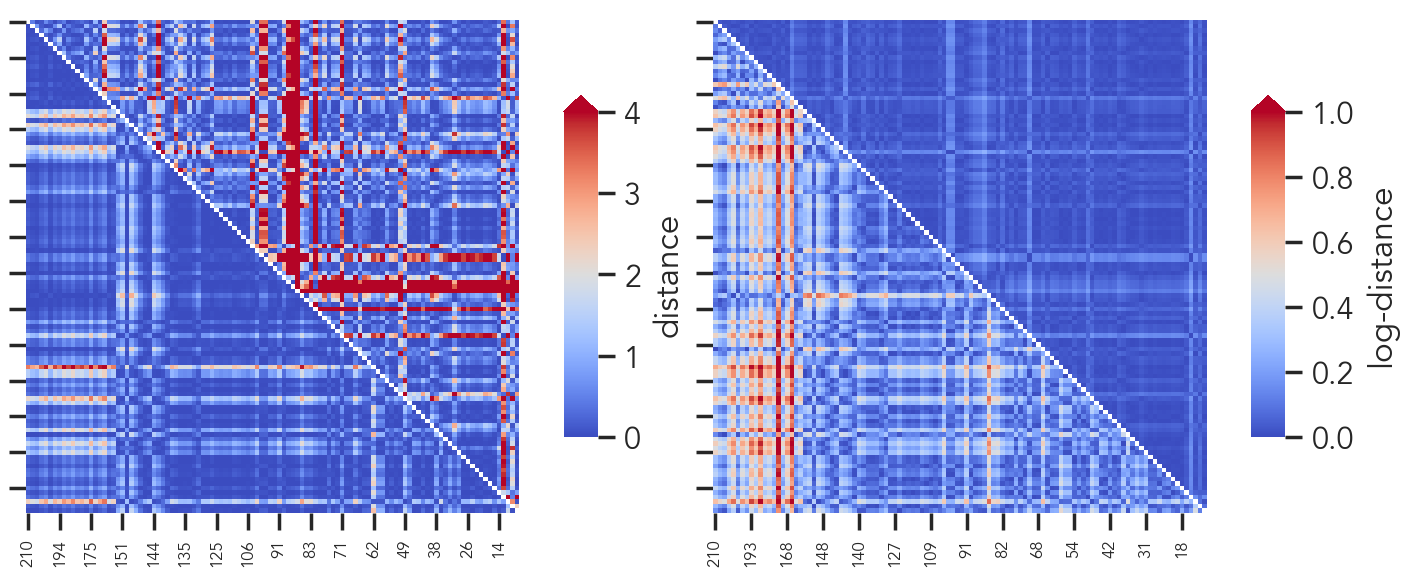

In [39]:
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharey=True, sharex=False, constrained_layout=True)

ax = axes[0]
mask = np.triu(np.ones_like(d_total, dtype=bool))
sns.heatmap(d_total, ax=ax, cmap='coolwarm', mask=mask, cbar_kws={'shrink': 0.5, 'pad':0.09, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'max',
                      'label': r'distance', 'aspect': 10}, square=True,
            vmin=0, vmax=4)
# reduce size of the labels



mask = np.tril(np.ones_like(d_bulk, dtype=bool))
sns.heatmap(d_bulk, ax=ax, cmap='coolwarm', mask=mask, square=True,
            vmin=0, vmax=4, cbar=False)

ax = axes[1]
mask = np.triu(np.ones_like(d_log_total, dtype=bool))
sns.heatmap(d_log_total, ax=ax, cmap='coolwarm', mask=mask, 
            cbar_kws={'shrink': 0.5, 'pad':0.09, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'max',
                      'label': r'log-distance', 'aspect': 10},
            square=True,
            vmin=0, vmax=1)

mask = np.tril(np.ones_like(d_log_bulk, dtype=bool))
sns.heatmap(d_log_bulk, ax=ax, cmap='coolwarm', mask=mask, square=True,
            vmin=0, vmax=4, cbar=False)

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [40]:
import numpy as np
from scipy.special import zeta

class Zipf:
    def __init__(self, alpha):
        self.alpha = alpha

# Helper function for generalized harmonic numbers
def harmonic(n, alpha):
    return sum(1 / (k ** alpha) for k in range(1, n + 1))

# Calculate the normalization constant (Riemann zeta function)
def normalization_constant(zipf):
    return zeta(zipf.alpha + 1)

# PDF of the Zipf distribution
def pdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    return x ** (-zipf.alpha - 1) / zeta_val

# CDF of the Zipf distribution
def cdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    H_x = harmonic(x, zipf.alpha + 1)
    return H_x / zeta_val

# Random sampling from the Zipf distribution
def zipfrand(zipf, max_val=10000):
    if zipf.alpha >= 1:
        u = np.random.rand()
        x = 1
        while cdf(zipf, x) < u:
            x += 1
        return x
    else:
        u = np.random.rand()
        left, right = 1, 2
        
        # Expand interval until one endpoint is below and the other is above `u`
        while cdf(zipf, right) < u:
            left = right
            right *= 2
            if right > max_val:
                right = max_val + 1
                break

        # Perform binary search within the identified interval
        while left < right:
            mid = int(np.sqrt(left * right))  # Logarithmic step: Geometric mean
            if cdf(zipf, mid) < u:
                left = mid + 1
            else:
                right = mid
        return left

In [41]:
zipf_dist = Zipf(alpha=0.5)
random_sample = zipfrand(zipf_dist)
print("Random sample from Zipf distribution:", random_sample)

Random sample from Zipf distribution: 546


In [42]:
S_bulk_empirical = SRF_gdf['richness_bulk'].values
S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
S_bulk_empirical

array([ 37.,   4.,  29.,   1.,  24.,  33.,  45., 111., 109.,  94.,  91.,
        85.,  28.,  27.,  40.,  18.,  79., 134.,   9., 205.,  55.,  32.,
       111., 149.,  21., 158.,   3.,  35.,  12.,  65., 116.,  41.,  24.,
       173., 238., 129.,  44.,  35.,  33.,   1.,  12.,   8.,  38., 111.,
        20., 208.,  66., 204., 124., 353., 466., 515.,  46.,  37.,  23.,
        15.,   1.,   1.,  50., 115.,  76.,  51.,  78.,  67., 194.,  97.,
        50.,  32.,  41., 100.,  38.,  38.,  10.,  34.,  70.,   7., 114.,
       128., 167.,  36.,   1., 113.,  82.,   7.,   4.,  12.,  19.,  16.,
        19.,  10.,  34.,  11.,   2.,  27., 246., 150.,  40.,  85., 330.,
        95., 136., 141., 174., 158., 134., 330., 215.,  84., 255.,  99.])

In [43]:
### H0
zipf_dist = Zipf(alpha=0.5)
# total 
S_bulk_empirical = SRF_gdf['richness_bulk'].values
S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
N_bulk_synthetic = np.array([
    np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_bulk_empirical[i]))]) for _ in range(10)])
    for i in range(len(S_bulk_empirical))
])
K_bulk_synthetic = S_bulk_empirical/N_bulk_synthetic**0.5
logK_bulk_synthetic = [np.abs(np.log10(K_bulk_synthetic[i])-np.log10(K_bulk_synthetic[j])) for i in range(len(K_bulk_synthetic)) for j in range(i+1, len(K_bulk_synthetic))]

S_total_empirical = SRF_gdf['richness_total'].values
S_total_empirical = S_total_empirical[S_total_empirical>0]
N_total_synthetic = np.array([
    np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_total_empirical[i]))]) for _ in range(10)])
    for i in range(len(S_total_empirical))
])
K_total_synthetic = S_total_empirical/N_total_synthetic**0.5
logK_total_synthetic = [np.abs(np.log10(K_total_synthetic[i])-np.log10(K_total_synthetic[j])) for i in range(len(K_total_synthetic)) for j in range(i+1, len(K_total_synthetic))]


In [45]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
text = '(A)'
ax.text(0.0, 1.1, text, fontsize=fontsize, ha='center', va='top', transform=ax.transAxes)
cmap = 'cividis'

cbar_ax = fig.add_axes([1.02, 0.84, 0.35, 0.035])
mask = np.triu(np.ones_like(d_log_total, dtype=bool))
sns.heatmap(d_log_total, ax=ax, cmap=cmap, mask=mask, 
            cbar_ax=cbar_ax,
            cbar_kws={'shrink': 0.35, 'pad':0.15, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      'extend':'max',
                      'label': r'$\log(K_{ij})$', 'aspect': 10},
            square=True,
            vmin=0, vmax=1)

mask = np.tril(np.ones_like(d_log_bulk, dtype=bool))
sns.heatmap(d_log_bulk, ax=ax, cmap=cmap, mask=mask, square=True,
            vmin=0, vmax=4, cbar=False)
ax.set_yticks(np.arange(0, len(d_log_total.columns), 1))
ax.set_yticklabels(d_log_total.columns, fontsize=3)
ax.set_xticks(np.arange(0, len(d_log_total.columns), 1))
ax.set_xticklabels(d_log_total.columns, fontsize=3)
ax.set_xlabel('')
ax.set_ylabel('')

ax.tick_params(
    axis='both',        # Apply changes to both x and y axes ('x', 'y', or 'both')
    which='both',       # Apply to both major and minor ticks ('major', 'minor', or 'both')
    direction='out',     # Direction of the ticks ('in', 'out', or 'inout')
    length=1,           # Length of the ticks
    width=0.1,            # Thickness of the ticks
    colors='k',      # Color of the ticks
    labelsize=3,       # Font size of the tick labels
    pad=5               # Distance between ticks and their labels
)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10, size=10)
# change the rotation of the labels
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0)
# change the rotation of the label

# draw a line to separate the bloom from the non-bloom stations
print(blooms_stations)
ax.axvline(blooms_stations, color='w', linestyle='-', linewidth=1)
ax.axhline(blooms_stations, color='w', linestyle='-', linewidth=1)

# Add annotation for bloom species
ax.text(x=blooms_stations/2, y=-2, s='species-rich\nhyperdominated', ha='center', va='bottom', fontsize=10)
ax.text(x=(len(d_log_total.columns)+blooms_stations)/2, y=-2, s='other stations', ha='center', va='bottom', fontsize=10)

ax.text(y=blooms_stations/2, x=len(d_log_total.columns)+2, s='species-rich\nhyperdominated', ha='left', va='center', fontsize=10, rotation=-90)
ax.text(y=(len(d_log_total.columns)+blooms_stations)/2, x=len(d_log_total.columns)+2, s='other stations', ha='left', va='center', fontsize=10, rotation=-90)


ax.text(len(d_log_total.columns)/2, 10+len(d_log_total.columns)/2, 'ALL OTUs', va='center', ha='center', rotation=-45, fontsize=14, color='w')
ax.text(8+len(d_log_total.columns)/2, len(d_log_total.columns)/2, 'NON-DOMINANT OTUs', va='center', ha='center', rotation=-45, fontsize=14, color='w')

# S = K N**0.5
# K = S N**-0.5
# err(S) \sqrt(S)
# S_1/S_2 = K_1/K_2 (N_1/N_2)**0.5
# log(K_1/K_2)
# d(i,j) = |log(k(i)) - log(k(j))| = d(j,i)

ax3 = fig.add_axes([1.07, 0.15, 0.3, 0.225])
ax2 = fig.add_axes([1.07, 0.48, 0.3, 0.225])
for ax in [ax2, ax3]:
    ax.set_ylabel('fraction of pairs', fontsize=fontsize-1, labelpad=2)
    ax.set_xlabel(r'$\log(K_{ij})$', fontsize=fontsize-1, labelpad=2)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=-1)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 0.55)

bins = np.arange(0, 1.5, 0.1)
d_log_total_values = d_log_total.mask(np.triu(np.ones_like(d_log_total, dtype=bool))).values
d_log_total_values = d_log_total_values[~np.isnan(d_log_total_values)]
sns.histplot(d_log_total_values, ax=ax2, bins=bins, kde=False, color='k', stat='probability' ) 
hist, bin_edges = np.histogram(logK_total_synthetic, bins=bins)
x_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
y_plot = hist/np.sum(hist)
sns.lineplot(x=x_plot, y=y_plot, ax=ax2, color='firebrick', linestyle='-', linewidth=1.5, marker='o', markersize=5, markeredgecolor='k')
text = 'neutral'
ax3.text(0.15, 0.5, text, fontsize=12, ha='left', va='top', transform=ax3.transAxes, color='firebrick')

d_log_bulk_values = d_log_bulk.mask(np.triu(np.ones_like(d_log_bulk, dtype=bool))).values
d_log_bulk_values = d_log_bulk_values[~np.isnan(d_log_bulk_values)]
sns.histplot(d_log_bulk_values, ax=ax3, bins=bins, kde=False, color='k', stat='probability' ) 
hist, bin_edges = np.histogram(logK_bulk_synthetic, bins=bins)
x_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
y_plot = hist/np.sum(hist)
sns.lineplot(x=x_plot, y=y_plot, ax=ax3, color='firebrick', linestyle='-', linewidth=1.5, marker='o', markersize=5, markeredgecolor='k')
text = 'neutral'
ax2.text(0.15, 0.5, text, fontsize=12, ha='left', va='top', transform=ax2.transAxes, color='firebrick')


text = '(B)'
ax2.text(-0.01, 1.02, text, fontsize=12, ha='right', va='bottom', transform=ax2.transAxes)

ax2.text(0.95, 0.08, 'all OTUs', fontsize=fontsize-2, ha='right', va='bottom', transform=ax2.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
ax3.text(0.95, 0.08, 'non-dominant\nOTUs', fontsize=fontsize-2, ha='right', va='bottom', transform=ax3.transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

text = '(C)'
ax3.text(-0.01, 1.02, text, fontsize=12, ha='right', va='bottom', transform=ax3.transAxes)

figname = 'Hyperdominated_K_log_distance.png'
fig.savefig(fig_dir+figname, bbox_inches='tight', dpi=300)


25


<Axes: ylabel='Count'>

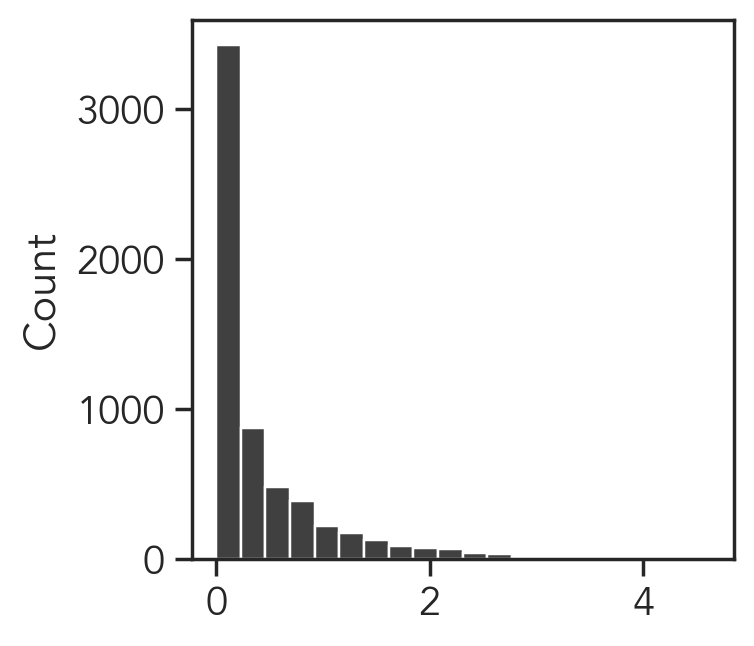

In [ ]:
fig, ax = plt.subplots()

# consider only the lower triangle
mask = np.triu(np.ones_like(d_total, dtype=bool))
# histplot of the distances of the K index in the lower triangle
data = d_total.values[~mask]
sns.histplot(data, bins=20, ax=ax, kde=False, color='black')

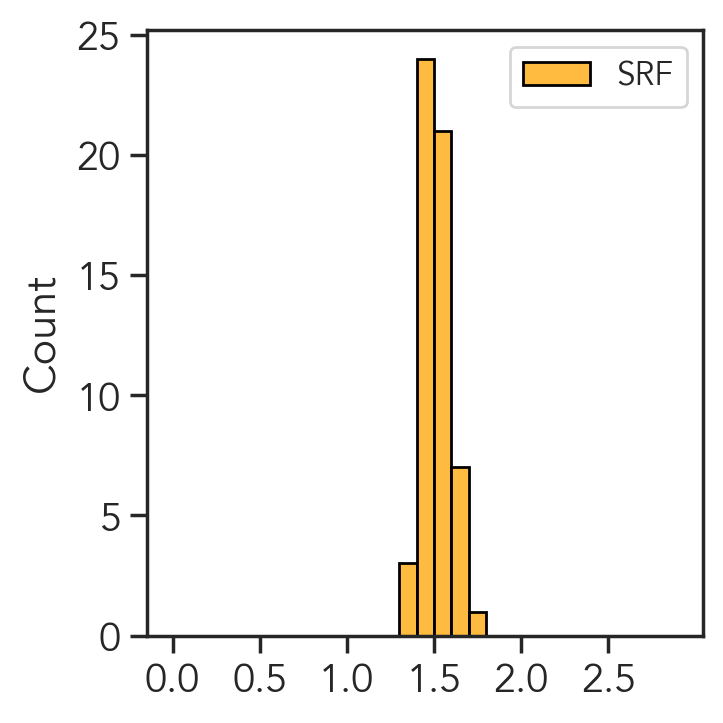

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)

#histplot of the bulk distribution only for SRF stations
ax.set_xticks(np.arange(0,3,0.5))
rho_bulk_SRF = [v+1 for k, v in rho_bulk.items() if k[-3:] == 'SRF']
sns.histplot(data=rho_bulk_SRF, bins=np.arange(0,3,0.1), color='orange', ax=ax, label='SRF', edgecolor='black', linewidth=1)
ax.legend(fontsize=12)


In [ ]:
#Abundances_SRF is Abundances of only SRF stations
#Abundances_DCM is Abundances of only DCM stations
columns = Abundances.columns
columns_SRF = [c for c in columns if c[-3:] == 'SRF']
columns_DCM = [c for c in columns if c[-3:] == 'DCM']
Abundances_SRF = Abundances[columns_SRF]
Abundances_DCM = Abundances[columns_DCM]
# rename Abundances_SRF stations by removing SRF and converting to integer
Abundances_SRF.columns = [int(c[:-4]) for c in Abundances_SRF.columns]
Abundances_SRF.head()
# sort Abundances_SRF by station from SRF_gdf
Abundances_SRF = Abundances_SRF[sorted_index[::-1]]
Abundances_SRF.to_csv('Abundances_SRF.csv')
Abundances_SRF.head()


7    8    11   12   14   18   20   22   23    
0007584343baed6a66bc624ab07afa51    0    0    0    0    0    0    0    0    0  \
000d7f48a59463756281b4ea64af743f    0    0    0    0    0    0    0    0    0   
001dedda63f65dd120ccef5ed9eff10a    0    0    0    0    0    0    0    0    0   
002590d1d8d94af8dfcf5980c719d116    0    0    0    0    0    0    0    0    0   
00374edaf2b110b52ffe3daea3626d01    0    0    0    0    0    0    0    0    0   

                                  24   ...  191  193  194  196  201  205  206   
0007584343baed6a66bc624ab07afa51    0  ...    0    0    0    0    0    0    0  \
000d7f48a59463756281b4ea64af743f    0  ...    0    0    0    0    0    0    0   
001dedda63f65dd120ccef5ed9eff10a    0  ...    0    0    2    0    0    0    5   
002590d1d8d94af8dfcf5980c719d116    0  ...    0    0    0    0    0    0    0   
00374edaf2b110b52ffe3daea3626d01    0  ...    0    0    0    0    0    0    0   

                                  208  209  210  
0007584343baed6a66bc624ab07afa51    0    0    0  
000d7f48a59463756281b4ea64af743f    0    0    0  
001dedda63f65dd120ccef5ed9eff10a    0    0    1  
002590d1d8d94af8dfcf5980c719d116    0    0    0  
00374edaf2b110b52ffe3daea3626d01    0    0    0  

[5 rows x 110 columns]

In [ ]:
SRF_gdf_filterd.columns

NameError: name 'SRF_gdf_filterd' is not defined

In [ ]:
SRF_gdf
# filter the SRF_gdf to keep only the stations that are in Abundances_SRF
SRF_gdf_filterd = SRF_gdf[SRF_gdf['station'].isin(Abundances_SRF.columns)]
SRF_gdf_filterd.iloc[:,:12].to_csv('SRF_gdf_filterd.csv')
SRF_gdf_filterd.head()

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0        7   37.0434     1.9493            SRF              9      9  727.0  \
1        8   38.0050     3.9899            SRF              9      9  717.0   
3       11   41.6645     2.7983            SRF              9     10    NaN   
4       12   43.3482     7.9010            SRF              5     10  675.0   
5       14   39.9100    12.8266            SRF              5     10  658.0   

    temp_woa    sal_woa   no3_woa  ...  biomass_total  relative_biomass_bloom   
0  25.320400  37.243389  0.654349  ...         7549.0                0.978938  \
1  25.628609  37.451500  0.212858  ...          780.0                0.989744   
3  21.630198  37.960928  0.007061  ...          619.0                0.865913   
4  20.361670  38.178169  0.006583  ...          399.0                0.994987   
5  22.406610  38.165199  0.130253  ...         2925.0                0.952137   

   relative_biomass_bulk  richness_bloom  richness_bulk  richness_total   
0               0.021062            20.0           37.0            57.0  \
1               0.010256            20.0            4.0            24.0   
3               0.134087            20.0           29.0            49.0   
4               0.005013            20.0            1.0            21.0   
5               0.047863            20.0           24.0            44.0   

   bloom    classes   K_total    K_bulk  
0  False  non-bloom  0.656040  2.934291  
1  False       poor  0.859338  1.414214  
3  False  non-bloom  1.969476  3.183164  
4   True       poor  1.051315  0.707107  
5  False  non-bloom  0.813560  2.028370  

[5 rows x 29 columns]

In [ ]:
! pwd

/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/code


In [ ]:
SRF_gdf

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0          7   37.0434     1.9493            SRF              9      9  727.0  \
1          8   38.0050     3.9899            SRF              9      9  717.0   
2         10   40.6541     2.8407            SRF              9      9  711.0   
3         11   41.6645     2.7983            SRF              9     10    NaN   
4         12   43.3482     7.9010            SRF              5     10  675.0   
..       ...       ...        ...            ...            ...    ...    ...   
129      205   72.4693   -71.8920            SRF              5     10  584.5   
130      206   70.9618   -53.6030            SRF              5     10  564.5   
131      208   69.1136   -51.5086            SRF              5     10  508.0   
132      209   64.7127   -53.0106            SRF              5     10  531.5   
133      210   61.5442   -55.9865            SRF              5     10  535.0   

      temp_woa    sal_woa   no3_woa  ...  biomass_total   
0    25.320400  37.243389  0.654349  ...         7549.0  \
1    25.628609  37.451500  0.212858  ...          780.0   
2    24.797300  37.925713  0.072777  ...          179.0   
3    21.630198  37.960928  0.007061  ...          619.0   
4    20.361670  38.178169  0.006583  ...          399.0   
..         ...        ...       ...  ...            ...   
129  -0.892610  31.219290  1.793274  ...      1558148.0   
130   2.437630  32.896900  1.785118  ...       364698.0   
131   2.938600  33.131413  1.630793  ...        27770.0   
132   2.517510  32.442013  3.216127  ...       240992.0   
133   5.203010  33.989799  3.419286  ...        70894.0   

     relative_biomass_bloom  relative_biomass_bulk  richness_bloom   
0                  0.978938               0.021062            20.0  \
1                  0.989744               0.010256            20.0   
2                  1.000000               0.000000            12.0   
3                  0.865913               0.134087            20.0   
4                  0.994987               0.005013            20.0   
..                      ...                    ...             ...   
129                0.993682               0.006318            20.0   
130                0.984667               0.015333            20.0   
131                0.954231               0.045769            20.0   
132                0.974132               0.025868            20.0   
133                0.978672               0.021328            20.0   

     richness_bulk  richness_total  bloom         classes   K_total    K_bulk  
0             37.0            57.0  False       non-bloom  0.656040  2.934291  
1              4.0            24.0  False            poor  0.859338  1.414214  
2              0.0            12.0   True            poor  0.896922       NaN  
3             29.0            49.0  False       non-bloom  1.969476  3.183164  
4              1.0            21.0   True            poor  1.051315  0.707107  
..             ...             ...    ...             ...       ...       ...  
129          330.0           350.0   True  hyperdominated  0.280391  3.325876  
130          215.0           235.0  False  hyperdominated  0.389136  2.875113  
131           84.0           104.0  False       non-bloom  0.624087  2.356169  
132          255.0           275.0  False       non-bloom  0.560185  3.229660  
133           99.0           119.0  False       non-bloom  0.446933  2.546005  

[133 rows x 29 columns]

In [ ]:
# SORT abundances stations by temperature from SRF_gdf 
Abundances_SRF = Abundances_SRF[[col for col in SRF_gdf.sort_values(by='latitude', ascending=True)['station'] if col in Abundances_SRF.columns]]
Abundances_SRF

86   87   88   85   84   89   83   82   81    
0007584343baed6a66bc624ab07afa51    0    0    0    0    0    0    0    4    0  \
000d7f48a59463756281b4ea64af743f    0    0    0    0    0    0    0    0    0   
001dedda63f65dd120ccef5ed9eff10a    0    0    0    0    0    0    0    0    0   
002590d1d8d94af8dfcf5980c719d116    0    1    0    0    0    0    0    0    0   
00374edaf2b110b52ffe3daea3626d01    0    0    0    0    0    0    0    0    0   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
ffbb560ce62f5a7dd92040a2be6fbcb4    0    0    0    0    0    0    0    0    0   
ffbec099d69da313c5253f88e48d23c9    0    0    0    0    0    0    0    0    0   
ffe268d3373da1dd4a156f814ccc09e8    0    4    9    0    0    0    0    0    0   
ffe8a780861ace578bc742dae5b7efa3    0    0    0    0    0    0    0    0    0   
fff7152fe79cb1a902216dfa9281d6e1    0    0    0    0    0    0    0    0    0   

                                  80   ...  168  194  201  180  163  178  189   
0007584343baed6a66bc624ab07afa51    0  ...    0    0    0    0    0    0    0  \
000d7f48a59463756281b4ea64af743f    0  ...    0    0    0    0    0    0    0   
001dedda63f65dd120ccef5ed9eff10a    0  ...    0    2    0    0    0    0    0   
002590d1d8d94af8dfcf5980c719d116    0  ...    0    0    0    0    0    0    0   
00374edaf2b110b52ffe3daea3626d01    0  ...    0    0    0    0    0    0    0   
...                               ...  ...  ...  ...  ...  ...  ...  ...  ...   
ffbb560ce62f5a7dd92040a2be6fbcb4    0  ...    0    0    0    0    0    0    0   
ffbec099d69da313c5253f88e48d23c9    0  ...    0    0    0    0    0    0    0   
ffe268d3373da1dd4a156f814ccc09e8    0  ...    0    0    0    0    0    0    0   
ffe8a780861ace578bc742dae5b7efa3    0  ...    0    0    1    0    0    0    0   
fff7152fe79cb1a902216dfa9281d6e1    0  ...    0   17    0    0    0    0    0   

                                  188  173  175  
0007584343baed6a66bc624ab07afa51    0    0    0  
000d7f48a59463756281b4ea64af743f    0    0    0  
001dedda63f65dd120ccef5ed9eff10a    0    0    0  
002590d1d8d94af8dfcf5980c719d116    0    0    0  
00374edaf2b110b52ffe3daea3626d01    0    0    0  
...                               ...  ...  ...  
ffbb560ce62f5a7dd92040a2be6fbcb4    0    0    0  
ffbec099d69da313c5253f88e48d23c9    0    1    2  
ffe268d3373da1dd4a156f814ccc09e8    0    0    0  
ffe8a780861ace578bc742dae5b7efa3    0    0    0  
fff7152fe79cb1a902216dfa9281d6e1    1    5   51  

[5830 rows x 110 columns]

In [ ]:
# learning curve adding stations in the order of the temperature
# compute the richness of the stations in the order of the temperature
richness_order = []
biomass = []

for i, col in enumerate(Abundances_SRF.columns):
    subset = Abundances_SRF[Abundances_SRF.columns[:i+1]]
    # sum the columns
    sums = subset.sum(axis=1)
    # count the positive values
    richness = len(sums[sums>0])
    richness_order.append(richness)
    biomass.append(Abundances_SRF[Abundances_SRF.columns[:i+1]].sum().sum())

In [ ]:
palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)

In [ ]:
from matplotlib.ticker import ScalarFormatter

In [ ]:
SRF_gdf

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0          7   37.0434     1.9493            SRF              9      9  727.0  \
1          8   38.0050     3.9899            SRF              9      9  717.0   
2         10   40.6541     2.8407            SRF              9      9  711.0   
3         11   41.6645     2.7983            SRF              9     10    NaN   
4         12   43.3482     7.9010            SRF              5     10  675.0   
..       ...       ...        ...            ...            ...    ...    ...   
129      205   72.4693   -71.8920            SRF              5     10  584.5   
130      206   70.9618   -53.6030            SRF              5     10  564.5   
131      208   69.1136   -51.5086            SRF              5     10  508.0   
132      209   64.7127   -53.0106            SRF              5     10  531.5   
133      210   61.5442   -55.9865            SRF              5     10  535.0   

      temp_woa    sal_woa   no3_woa  ...  biomass_total   
0    25.320400  37.243389  0.654349  ...         7549.0  \
1    25.628609  37.451500  0.212858  ...          780.0   
2    24.797300  37.925713  0.072777  ...          179.0   
3    21.630198  37.960928  0.007061  ...          619.0   
4    20.361670  38.178169  0.006583  ...          399.0   
..         ...        ...       ...  ...            ...   
129  -0.892610  31.219290  1.793274  ...      1558148.0   
130   2.437630  32.896900  1.785118  ...       364698.0   
131   2.938600  33.131413  1.630793  ...        27770.0   
132   2.517510  32.442013  3.216127  ...       240992.0   
133   5.203010  33.989799  3.419286  ...        70894.0   

     relative_biomass_bloom  relative_biomass_bulk  richness_bloom   
0                  0.978938               0.021062            20.0  \
1                  0.989744               0.010256            20.0   
2                  1.000000               0.000000            12.0   
3                  0.865913               0.134087            20.0   
4                  0.994987               0.005013            20.0   
..                      ...                    ...             ...   
129                0.993682               0.006318            20.0   
130                0.984667               0.015333            20.0   
131                0.954231               0.045769            20.0   
132                0.974132               0.025868            20.0   
133                0.978672               0.021328            20.0   

     richness_bulk  richness_total  bloom         classes   K_total    K_bulk  
0             37.0            57.0  False       non-bloom  0.656040  2.934291  
1              4.0            24.0  False            poor  0.859338  1.414214  
2              0.0            12.0   True            poor  0.896922       NaN  
3             29.0            49.0  False       non-bloom  1.969476  3.183164  
4              1.0            21.0   True            poor  1.051315  0.707107  
..             ...             ...    ...             ...       ...       ...  
129          330.0           350.0   True  hyperdominated  0.280391  3.325876  
130          215.0           235.0  False  hyperdominated  0.389136  2.875113  
131           84.0           104.0  False       non-bloom  0.624087  2.356169  
132          255.0           275.0  False       non-bloom  0.560185  3.229660  
133           99.0           119.0  False       non-bloom  0.446933  2.546005  

[133 rows x 29 columns]

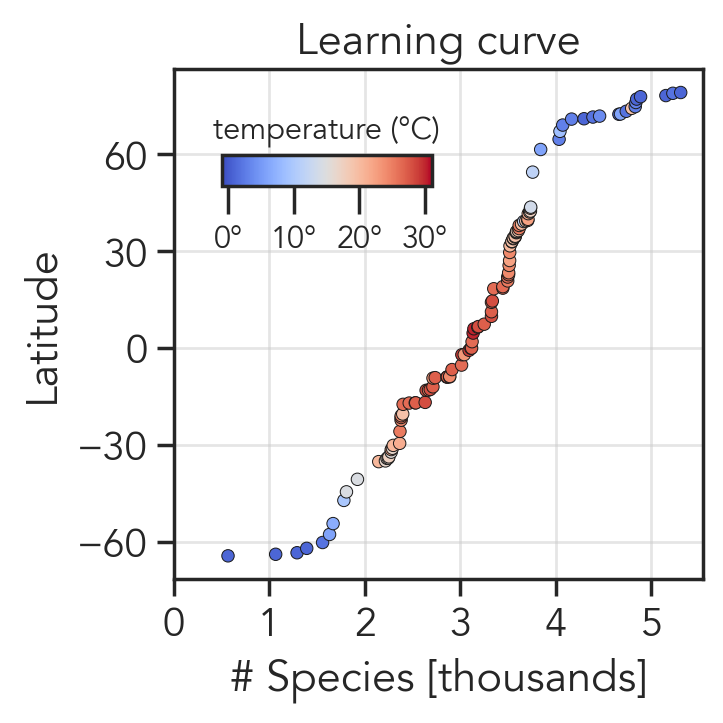

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)
richness_order = np.array(richness_order)
latitude_order = [SRF_gdf.loc[SRF_gdf['station']==station, 'latitude'].values[0] for station in Abundances_SRF.columns]
colors_order = [palette[1+int(SRF_gdf.loc[SRF_gdf['station']==station, 'temp_woa'].values[0])] for station in Abundances_SRF.columns]
#sns.scatterplot(x=latitude_order, y=richness_order, color='forestgreen', edgecolor='k', ax=ax)
sns.scatterplot(y=latitude_order, x=richness_order, color=colors_order, edgecolor='k', ax=ax, s=20, lw=1)
ax.set_ylabel('Latitude')
ax.set_title('Learning curve')
ax.set_xlabel('# Species [thousands]')
ax.set_yticks(np.arange(-60, 90, 30))
ax.set_xticks(np.arange(0, 6e3, 1e3))
# format of xticks is scientific
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.set_xticklabels([f'{int(x/1e3)}' for x in ax.get_xticks()])

cax = fig.add_axes([0.3, 0.75, 0.3, 0.045])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)


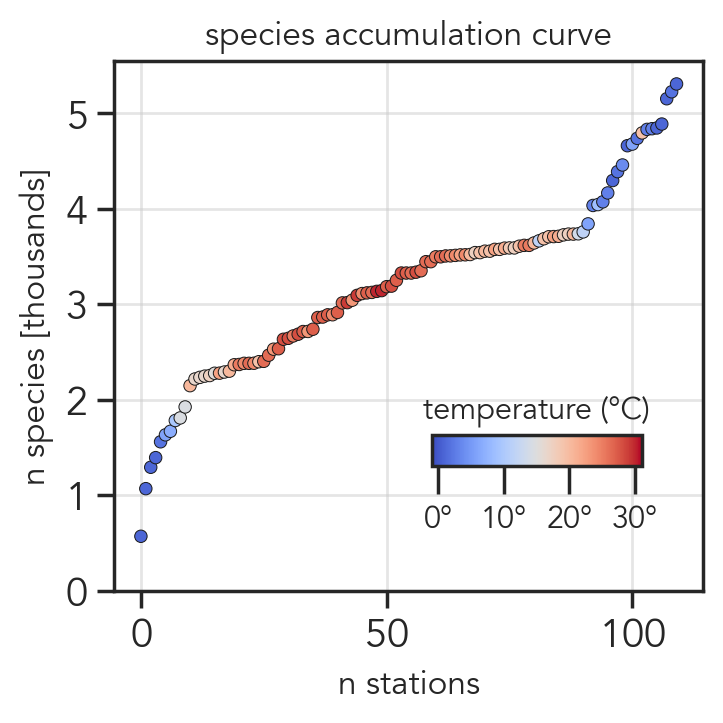

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)
richness_order = np.array(richness_order)
latitude_order = [SRF_gdf.loc[SRF_gdf['station']==station, 'latitude'].values[0] for station in Abundances_SRF.columns]
colors_order = [palette[1+int(SRF_gdf.loc[SRF_gdf['station']==station, 'temp_woa'].values[0])] for station in Abundances_SRF.columns]
#sns.scatterplot(x=latitude_order, y=richness_order, color='forestgreen', edgecolor='k', ax=ax)
sns.scatterplot(x=np.arange(len(latitude_order)), y=richness_order, color=colors_order, edgecolor='k', ax=ax, s=20, lw=1)
ax.set_xlabel('n stations', fontsize=12)    
ax.set_title('species accumulation curve', fontsize=12)  
ax.set_ylabel(r'n species [thousands]', fontsize=12)  
ax.set_yticks(np.arange(0, 6e3, 1e3))
# format of xticks is scientific
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.set_yticklabels([f'{int(x/1e3)}' for x in ax.get_yticks()])

cax = fig.add_axes([0.6, 0.35, 0.3, 0.045])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)

figname = 'species_accumulation_curve.png'
fig.savefig(figname, dpi=300, bbox_inches='tight')


In [ ]:
! pwd

/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/Pigani HayMele et al 2024/downscaling_richness/code


In [ ]:
# dominant species are the top 20 species of each station
 
dominant_species = [Abundances_SRF[Abundances_SRF.columns[:i+1]].sum(axis=1).sort_values(ascending=False).index[:20] for i in range(len(Abundances_SRF.columns))]
dominant_species = np.unique(np.concatenate(dominant_species))
print(dominant_species)

['00b5bb3b1cae64e4d2761e16fc91b2cb' '039a44f7c456a8d518a656d4bddb3594'
 '044e857fc8eb5fd22318010046f420af' '0dee4375a6cbe9d2a091e451b1a96370'
 '14b113961e0805fb5e1bb3b40d828f52' '14d6921f8bc3cf5beeb7e09e97590b44'
 '1a3552c223231f0691e3309b22560e91' '1dd232dc11ab0be77562507e2cd0e920'
 '1e603b319d769d234717b272f9ec8975' '23f9d501a385822185c98c43e4aa6138'
 '2441f754a9a8bea98182423c1e6a7158' '286d0a7b136ce52d173a14a049bc850a'
 '30191c0570b3035d38a5bc7cc8738a04' '306a2eb17ca434af18012e3022e25711'
 '361acffd0e91f5773bfb02e52fcb2c60' '383cc84a981b56d04f96f0be21dd64e4'
 '397910ebcdb4f9a593e2df561dc633a7' '4e1edcb4e329a5b98ca74046f50a3330'
 '50f50e84fa60a9cc983622dab6138115' '5b2d83f3819947079d346cf06dd3b9dd'
 '62e00c51a8e933d08fc96cfec5144a95' '65cc2b94239670a78850e9f6afda260e'
 '683e0a6d1346556f20c56daeeeeff403' '6d2848220b25d52137b36be6a85c69d9'
 '7439fbf150289665aa6caa873eafc8af' '75e1bd21dc35335d7744c97ecf12417b'
 '83866f324e2d4a759347ff72721f3af3' '8414dafcda9e42b8a673e888e2fbf496'
 '8717

In [ ]:
dominant_species

array(['00b5bb3b1cae64e4d2761e16fc91b2cb',
       '039a44f7c456a8d518a656d4bddb3594',
       '044e857fc8eb5fd22318010046f420af',
       '0dee4375a6cbe9d2a091e451b1a96370',
       '14b113961e0805fb5e1bb3b40d828f52',
       '14d6921f8bc3cf5beeb7e09e97590b44',
       '1a3552c223231f0691e3309b22560e91',
       '1dd232dc11ab0be77562507e2cd0e920',
       '1e603b319d769d234717b272f9ec8975',
       '23f9d501a385822185c98c43e4aa6138',
       '2441f754a9a8bea98182423c1e6a7158',
       '286d0a7b136ce52d173a14a049bc850a',
       '30191c0570b3035d38a5bc7cc8738a04',
       '306a2eb17ca434af18012e3022e25711',
       '361acffd0e91f5773bfb02e52fcb2c60',
       '383cc84a981b56d04f96f0be21dd64e4',
       '397910ebcdb4f9a593e2df561dc633a7',
       '4e1edcb4e329a5b98ca74046f50a3330',
       '50f50e84fa60a9cc983622dab6138115',
       '5b2d83f3819947079d346cf06dd3b9dd',
       '62e00c51a8e933d08fc96cfec5144a95',
       '65cc2b94239670a78850e9f6afda260e',
       '683e0a6d1346556f20c56daeeeeff403',
       '6d2

In [ ]:
topID_metaB_key['total_abundance'] = {species: Abundances_SRF.loc[species].sum() for species in dominant_species}
topID_metaB_key.sort_values(by='total_abundance', ascending=False, inplace=True)

In [ ]:
topID_metaB_key

taxon       level   
md5sum                                                                     
30191c0570b3035d38a5bc7cc8738a04     Actinocyclus curvulatus     species  \
cf7d6062d57f5919cac2af3d59d30b27           Bacillariophyceae       class   
928371a2f97bb272473c6fd6d0af2b12       Chaetoceros rostratus     species   
d9fba6377f54ac59eb080a698fb80b5a                   Proboscia       genus   
039a44f7c456a8d518a656d4bddb3594          Odontella sinensis     species   
ce119ed148d7106582ddebac1983a3ec              Leptocylindrus       genus   
91a0bf62bf8dc9a63294b12e76618a1f            Rhizosolenianae   superorder   
50f50e84fa60a9cc983622dab6138115                         NaN         NaN   
683e0a6d1346556f20c56daeeeeff403        Thalassiosira tumida     species   
d48b807afa0c0eebbac0ec98aa538cf7          Corethron pennatum     species   
6d2848220b25d52137b36be6a85c69d9  Pseudo-nitzschia australis     species   
d43eb454762ead10d8b0d8e4ba30c93a                Mediophyceae       class   
f75ad4c6d7d0dc51a0a6c2f54ca770da                 Chaetoceros       genus   
306a2eb17ca434af18012e3022e25711            Rhizosolenianae   superorder   
1dd232dc11ab0be77562507e2cd0e920                         NaN         NaN   
83866f324e2d4a759347ff72721f3af3                Mediophyceae       class   
044e857fc8eb5fd22318010046f420af                 Chaetoceros       genus   
286d0a7b136ce52d173a14a049bc850a                    Eucampia       genus   
0dee4375a6cbe9d2a091e451b1a96370          Guinardia flaccida     species   
14d6921f8bc3cf5beeb7e09e97590b44                Mediophyceae       class   
8fd6d889852840ef8c8863cebdc14d10                 Chaetoceros       genus   
7439fbf150289665aa6caa873eafc8af                    Eucampia       genus   
b2e9f48be39b8f9377a419d4175b9b67   Thalassiosira weissflogii     species   
f2f8b6bc0f4f3b6be690e0bd0f740a20           Bacillariophyceae       class   
397910ebcdb4f9a593e2df561dc633a7                         NaN         NaN   
e4fe00a262c34aae5094a38778b7d65b            Pseudo-nitzschia       genus   
00b5bb3b1cae64e4d2761e16fc91b2cb                   Proboscia       genus   
ae808698d6131569f7b5a8abd09f497a                   Proboscia       genus   
ba6c7a54f4f24e0888797d4e062cda61           Bacillariophyceae       class   
c4d788e6c265447f45dd4d78cf9ab7a3                   Proboscia       genus   
75e1bd21dc35335d7744c97ecf12417b          Guinardia flaccida     species   
65cc2b94239670a78850e9f6afda260e            Rhizosolenianae   superorder   
14b113961e0805fb5e1bb3b40d828f52            Corethron inerme     species   
2441f754a9a8bea98182423c1e6a7158       Rhizosolenia setigera     species   
1a3552c223231f0691e3309b22560e91               Thalassiosira       genus   
1e603b319d769d234717b272f9ec8975           Bacillariophyceae       class   
8cb0fcfac5a493640f2e00bd0ee70b77      Coscinodiscus radiatus     species   
871715bf8be0ca1ae9ae3c263fc36f6e         Coscinodiscophyceae       class   
383cc84a981b56d04f96f0be21dd64e4     Rhizosolenia shrubsolei     species   
fc299706603f994403ce7f061cf36ccf            Rhizosolenianae   superorder   
4e1edcb4e329a5b98ca74046f50a3330           Bacillariophyceae       class   
dc494ebe10f117b338dafd6a7800cd60          Odontella sinensis     species   
23f9d501a385822185c98c43e4aa6138          Odontella sinensis     species   
dd3d5f3e3c9ce26919e756a2f1c838ea          Odontella sinensis     species   
5b2d83f3819947079d346cf06dd3b9dd                         NaN         NaN   
62e00c51a8e933d08fc96cfec5144a95          Odontella sinensis     species   
d8ef5dceefca0c9784ea1b34c122161a        Thalassiosira tumida     species   
8414dafcda9e42b8a673e888e2fbf496          Navicula perminuta     species   
9e949bb32740add258ec93077b0c09aa  Asterionellopsis glacialis     species   
361acffd0e91f5773bfb02e52fcb2c60        Thalassiosira tumida     species   

                                  total_abundance  
md5sum                                            

In [ ]:
richness_order_dominant = []
biomass_dominant = []

for i, col in enumerate(Abundances_SRF.columns):
    subset = Abundances_SRF.loc[dominant_species][Abundances_SRF.columns[:i+1]]
    # sum the columns
    sums = subset.sum(axis=1)
    # count the positive values
    richness = len(sums[sums>0])
    richness_order_dominant.append(richness)
    biomass_dominant.append(Abundances_SRF.loc[dominant_species][Abundances_SRF.columns[:i+1]].sum().sum())
    
print(len(richness_order_dominant))

123


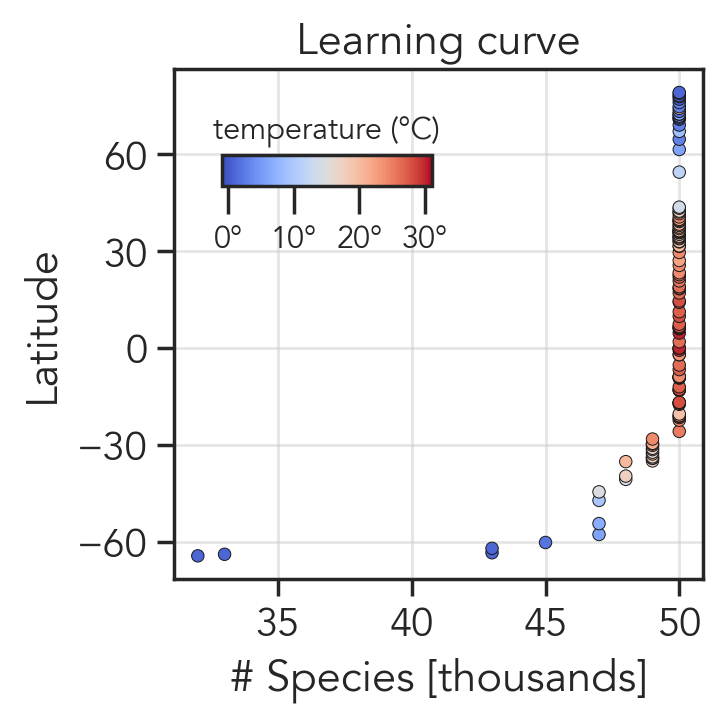

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)
richness_order_dominant = np.array(richness_order_dominant)
latitude_order = [SRF_gdf.loc[SRF_gdf['station']==station, 'latitude'].values[0] for station in Abundances_SRF.columns]
colors_order = [palette[1+int(SRF_gdf.loc[SRF_gdf['station']==station, 'temp_woa'].values[0])] for station in Abundances_SRF.columns]
#sns.scatterplot(x=latitude_order, y=richness_order, color='forestgreen', edgecolor='k', ax=ax)
sns.scatterplot(y=latitude_order, x=richness_order_dominant, color=colors_order, edgecolor='k', ax=ax, s=20, lw=1)
ax.set_ylabel('Latitude')
ax.set_title('Learning curve')
ax.set_xlabel('# Species [thousands]')
ax.set_yticks(np.arange(-60, 90, 30))
#ax.set_xticks(np.arange(0, 6e3, 1e3))
# format of xticks is scientific
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.set_xticklabels([f'{int(x/1e3)}' for x in ax.get_xticks()])

cax = fig.add_axes([0.3, 0.75, 0.3, 0.045])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)


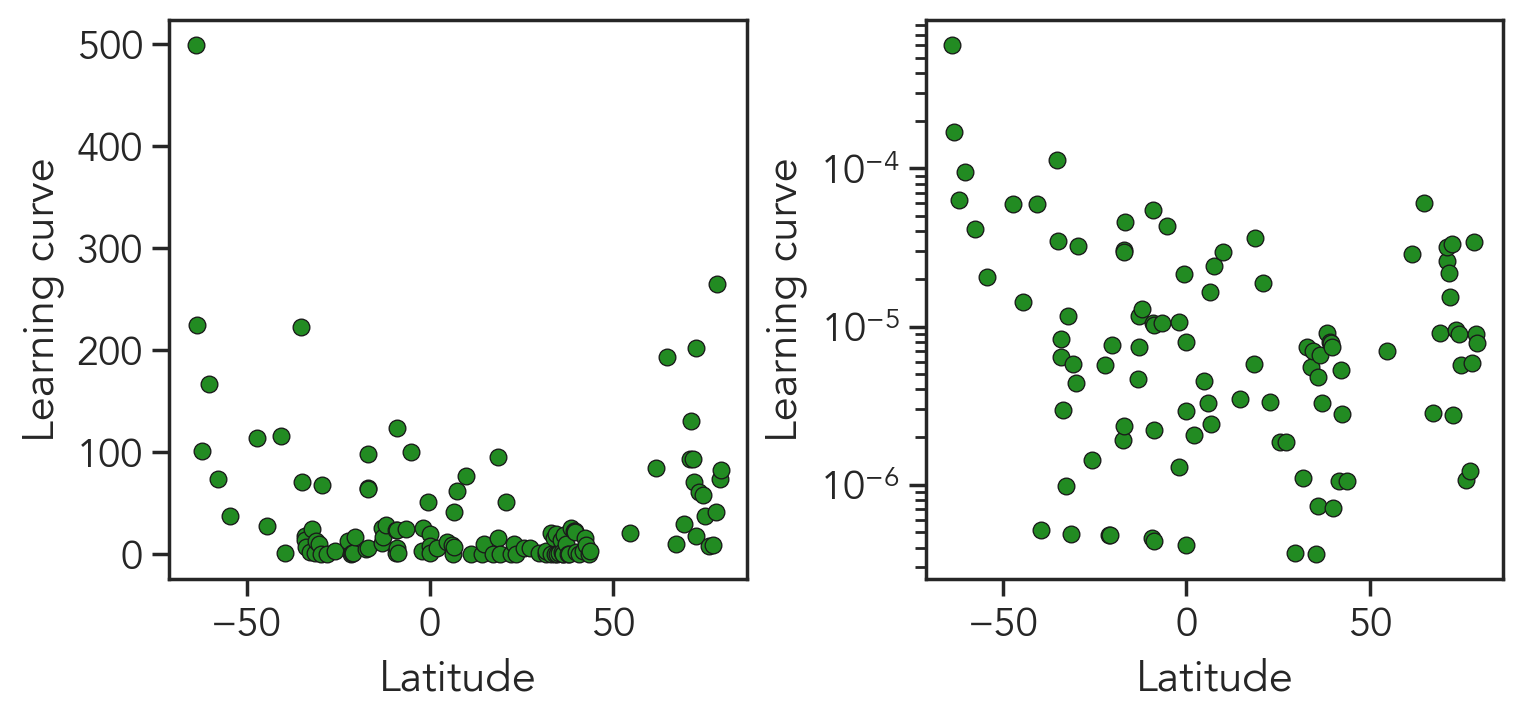

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7.5,3.5), constrained_layout=True)
ax = axes[0]
x = latitude_order[1:]
sns.scatterplot(x=x, y=(richness_order[1:]-richness_order[:-1]), color='forestgreen', edgecolor='k', ax=ax)
ax.set_xlabel('Latitude')
ax.set_ylabel('Learning curve')
#ax.set_yscale('log')

ax = axes[1]
sns.scatterplot(x=x, y=(richness_order[1:]-richness_order[:-1])/biomass[1:], color='forestgreen', edgecolor='k', ax=ax)
ax.set_xlabel('Latitude')
ax.set_ylabel('Learning curve')
ax.set_yscale('log')

0007584343baed6a66bc624ab07afa51    0.008130
000d7f48a59463756281b4ea64af743f    0.000000
001dedda63f65dd120ccef5ed9eff10a    0.024390
002590d1d8d94af8dfcf5980c719d116    0.008130
00374edaf2b110b52ffe3daea3626d01    0.016260
                                      ...   
ffbb560ce62f5a7dd92040a2be6fbcb4    0.016260
ffbec099d69da313c5253f88e48d23c9    0.016260
ffe268d3373da1dd4a156f814ccc09e8    0.024390
ffe8a780861ace578bc742dae5b7efa3    0.008130
fff7152fe79cb1a902216dfa9281d6e1    0.065041
Length: 5830, dtype: float64


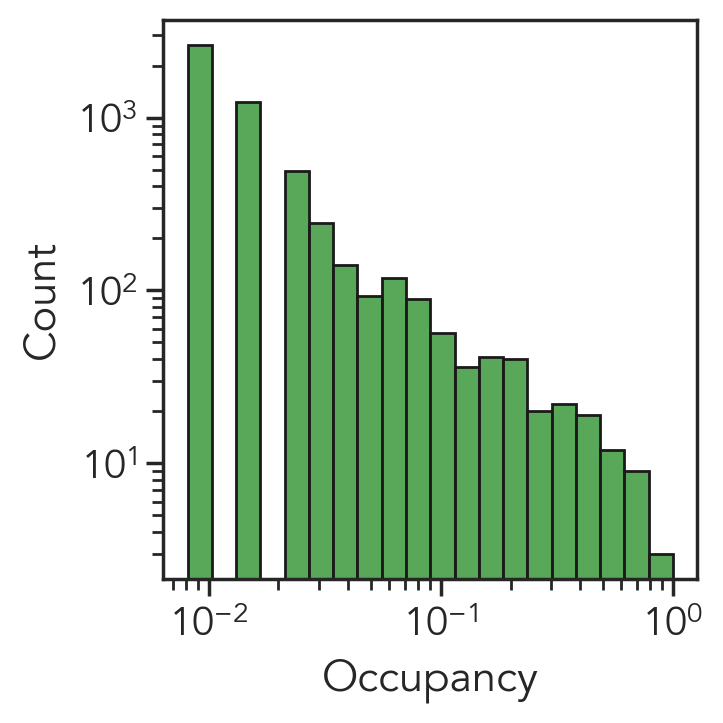

In [ ]:
relative_occupancies = Abundances_SRF.astype(bool).sum(axis=1)/len(Abundances_SRF.columns)
print(relative_occupancies)

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)
bins = np.logspace(np.log10(1/len(Abundances_SRF.columns)), 0, 21)
sns.histplot(relative_occupancies, bins=bins, ax=ax, color='forestgreen', edgecolor='k', linewidth=1)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.set_xscale('log')


In [ ]:
print(len(Abundances_SRF.columns))

123


0007584343baed6a66bc624ab07afa51    1
000d7f48a59463756281b4ea64af743f    0
001dedda63f65dd120ccef5ed9eff10a    3
002590d1d8d94af8dfcf5980c719d116    1
00374edaf2b110b52ffe3daea3626d01    2
                                   ..
ffbb560ce62f5a7dd92040a2be6fbcb4    2
ffbec099d69da313c5253f88e48d23c9    2
ffe268d3373da1dd4a156f814ccc09e8    3
ffe8a780861ace578bc742dae5b7efa3    1
fff7152fe79cb1a902216dfa9281d6e1    8
Length: 5830, dtype: int64


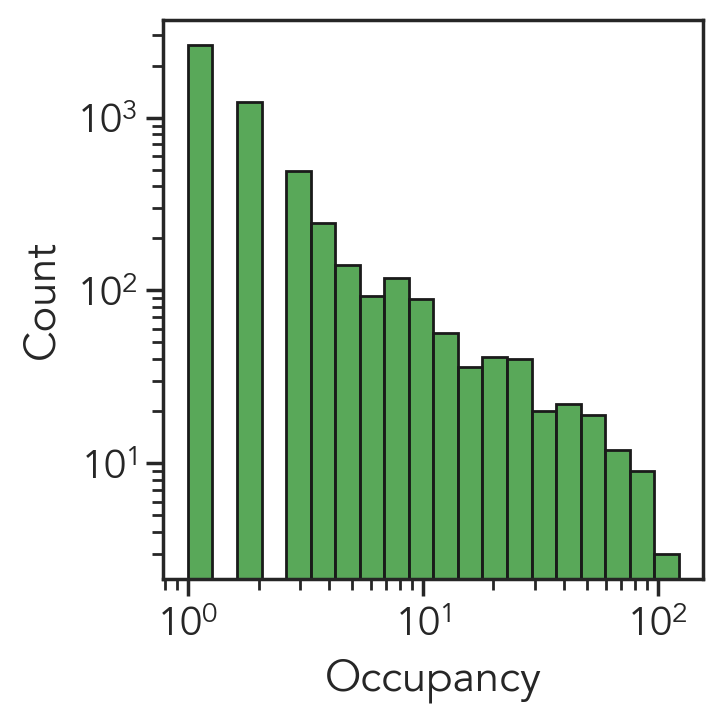

In [ ]:
occupancies = Abundances_SRF.astype(bool).sum(axis=1)#/len(Abundances_SRF.columns)
print(occupancies)

fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)
bins = np.logspace(np.log10(1), np.log10(len(Abundances_SRF.columns)), 21)
sns.histplot(occupancies, bins=bins, ax=ax, color='forestgreen', edgecolor='k', linewidth=1)
ax.set_xlabel('Occupancy')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
Abundances_SRF.shape

(5830, 123)

In [ ]:
#relative_Abundances_SRF = Abundances_SRF/Abundances_SRF.sum(axis=0)
mean, std = Abundances_SRF.mean(axis=1), Abundances_SRF.std(axis=1)
Ns = Abundances_SRF.sum(axis=0)
alpha, beta = mean**2/std, std/mean
print(alpha, beta)
expected_occupancies = []
for i in range(Abundances_SRF.shape[0]):
    sum_i = 0
    for j in range(Abundances_SRF.shape[1]):
        sum_i += (1+Ns.iloc[j]*mean.iloc[i]/beta.iloc[i])**(-beta.iloc[i])
    sum_i /= Abundances_SRF.shape[1]
    expected_occupancies.append(1-sum_i)

0007584343baed6a66bc624ab07afa51    0.002932
000d7f48a59463756281b4ea64af743f         NaN
001dedda63f65dd120ccef5ed9eff10a    0.008606
002590d1d8d94af8dfcf5980c719d116    0.000733
00374edaf2b110b52ffe3daea3626d01    0.002082
                                      ...   
ffbb560ce62f5a7dd92040a2be6fbcb4    0.004453
ffbec099d69da313c5253f88e48d23c9    0.002960
ffe268d3373da1dd4a156f814ccc09e8    0.014574
ffe8a780861ace578bc742dae5b7efa3    0.000733
fff7152fe79cb1a902216dfa9281d6e1    0.259110
Length: 5830, dtype: float64 0007584343baed6a66bc624ab07afa51    11.090537
000d7f48a59463756281b4ea64af743f          NaN
001dedda63f65dd120ccef5ed9eff10a     7.557820
002590d1d8d94af8dfcf5980c719d116    11.090537
00374edaf2b110b52ffe3daea3626d01     7.809987
                                      ...    
ffbb560ce62f5a7dd92040a2be6fbcb4     9.127835
ffbec099d69da313c5253f88e48d23c9     8.239250
ffe268d3373da1dd4a156f814ccc09e8     7.809987
ffe8a780861ace578bc742dae5b7efa3    11.090537
fff7152fe79cb1a9

<Axes: >

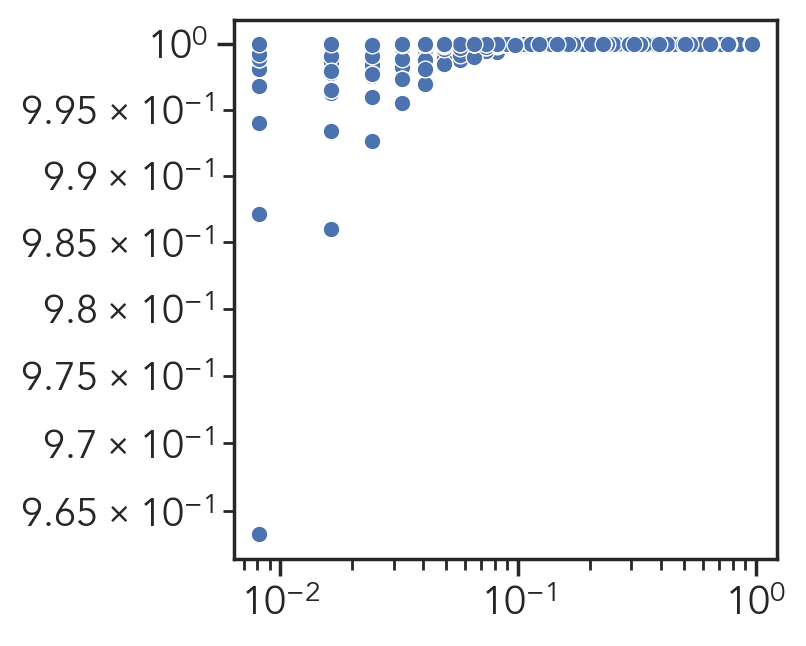

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

sns.scatterplot(x=relative_occupancies, y = expected_occupancies)

<Axes: >

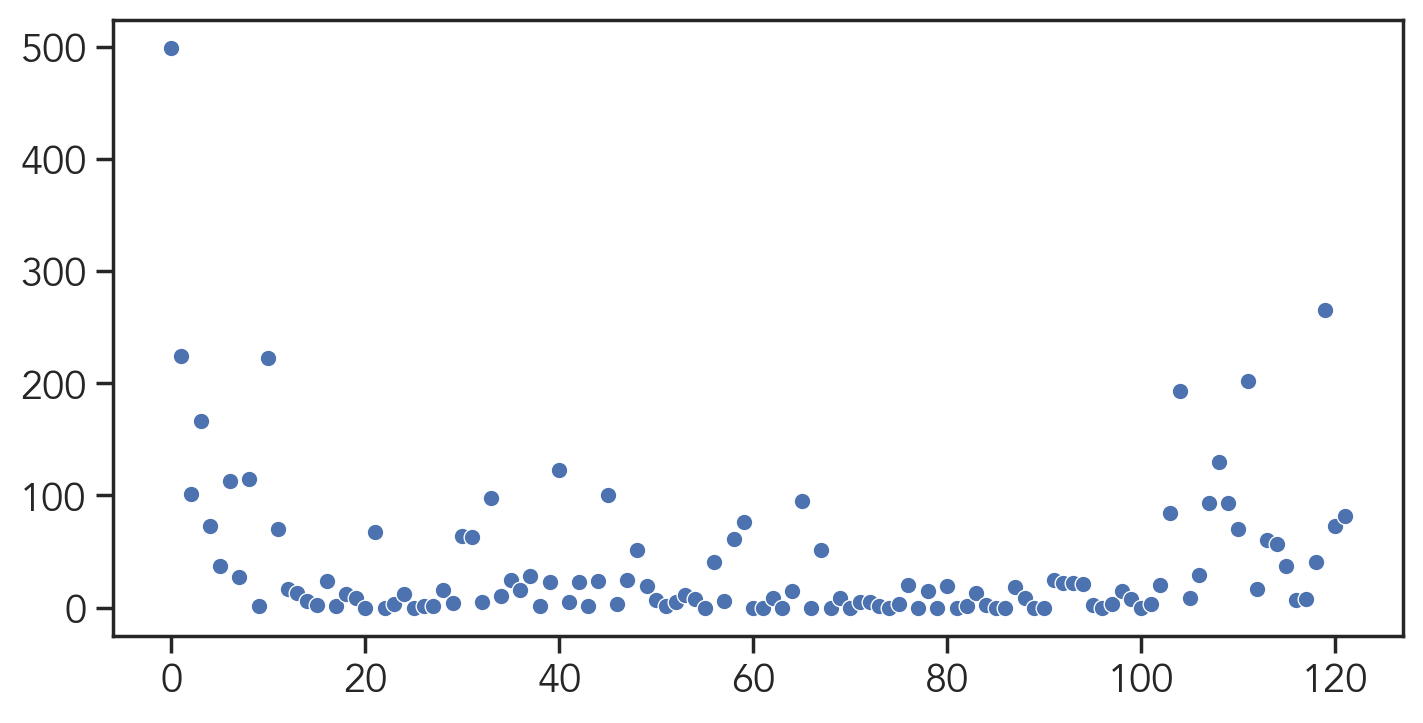

In [ ]:
stations =Abundances_SRF.columns
#temperatures = [SRF_gdf.loc[station, 'temp_woa'] for station in stations]
richness_order = np.array(richness_order)
fig, ax = plt.subplots(1,1, figsize=(7,3.5), constrained_layout=True)
learning_curve =richness_order[1:]-richness_order[:-1]
sns.scatterplot(learning_curve, ax=ax)


In [ ]:
learning_curve

array([499, 224, 101, 166,  73,  37, 113,  27, 115,   1, 222,  70,  17,
        13,   6,   2,  24,   1,  12,   9,   0,  67,   0,   3,  12,   0,
         1,   1,  16,   4,  64,  63,   5,  98,  10,  25,  16,  28,   1,
        23, 123,   5,  23,   1,  24, 100,   3,  25,  51,  19,   7,   1,
         5,  11,   8,   0,  41,   6,  61,  76,   0,   0,   9,   0,  15,
        95,   0,  51,   0,   9,   0,   5,   5,   1,   0,   3,  20,   0,
        15,   0,  19,   0,   1,  13,   2,   0,   0,  18,   9,   0,   0,
        25,  22,  22,  21,   2,   0,   3,  15,   8,   0,   3,  20,  84,
       193,   9,  29,  93, 130,  93,  70, 202,  17,  60,  57,  37,   7,
         8,  41, 265,  73,  82])

In [ ]:
richness = sums[sums>0].count()
richness

50

In [ ]:
len(sums[sums>0])

50

In [ ]:
a = 2

In [ ]:
np.log10(a)

0.3010299956639812

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(3.5,3.5), constrained_layout=True)7

# A is a random matrix with diagonal -1, N=1000 elements, C=0.1, sigma=0.1
A = np.random.rand(1000,1000)
A = A - np.diag(np.diag(A))
N = 1000
C = 0.1
sigma = 0.1

SyntaxError: invalid syntax (2524338961.py, line 1)